This script will
- Get data from stations
- Get processed altimeter data
- Plot data location
- Plot time series altimeter and station
- Calculate and Plot accuracies
- Separate low level from high levels

In [1]:
from ground_data import GroundObservations
from ts_preprocesing import *#get_date_time_cols
import scipy.interpolate as sc
import geopandas as gpd
from timezonefinder import TimezoneFinder
# from ts_preprocesing import convert_units
import importlib
import pandas as pd
import os
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
import pytz
from pytz import timezone
import timeit
from datetime import datetime
utc=pytz.utc
utc.zone
%load_ext autoreload
%autoreload 2

In [2]:
#Test Getting data from stations
#So far what works
# Getting locss stations
# Getting ARHN stations 
# Getting USGS stations from file. Still working on R script connection
go=GroundObservations()
height_fd='height'

lc_lakes=['KHB2','HMT2','PHN2','SAW2','RAW2','BTN2','QUL2', 'WEW2', 'CFN2','YSL2','SLL2','TAB2','MAB2']
df_locss=go.read_ground_data('LOCSS', station_id=lc_lakes)
df_locss=get_date_time_cols(df_locss, 'date', has_hour=True)
stations=df_locss['gauge_id'].unique()
df_final=convert_units(df_locss,height_fd, origin='FEET', to='METER', check_col=True, unit_fd='unit',
                  gauge_fd='gauge_id')


##'2102' Is a meteorlogical station 

ar_lakes=['1805', '1819', '1824', '2830', '1830','2832', '2028','2231','2234','2300','2316']
skip_rows=1

df_arhn=go.read_ground_data('ARHN', skip_rows=skip_rows, station_id=ar_lakes)
df_arhn=get_date_time_cols(df_arhn, 'date', has_hour=True)

us_lakes=['2464800','6903880','6604000']
df_usgs=go.read_ground_data('USGS',station_id=us_lakes)
df_usgs=get_date_time_cols(df_usgs, 'date')
df_usgs=convert_units(df_usgs,height_fd, origin='FEET', to='METER', check_col=False, unit_fd='unit',
                  gauge_fd='gauge_id')
# df_usgs.height.hist()
# df_usgs.height_rw.hist()#head()
rvbr_lakes=['19069','19060','19126']
df_rvbr=go.read_ground_data('RVBR', station_id=rvbr_lakes)
df_rvbr=get_date_time_cols(df_rvbr,'date')

#falta Brazil
# df['file_name'].str.split('_', expand=True)


19069 ['br_19069_MACHADINHO.xlsx']
19060 ['br_19060_SEGREDO.xlsx']
19126 ['br_19126_XINGO.xlsx']


In [3]:
#Relevant columns
# df_ground_ts=pd.DataFrame()
common_cols=['gauge_id','source','decimal_y','height','date','year', 'month', 'day', 'hour']
df_usgs[common_cols]
df_ground_ts=pd.concat((df_usgs[common_cols].copy(),df_arhn[common_cols].copy(), df_final[common_cols].copy(), df_rvbr[common_cols].copy()), axis=0)
# pd.datetime(+pd.to_datetime(df_final['time'], format='%H:%M:%S'), format='%Y-%m-%d %H:%M:%S')
df_ground_ts.columns

Index(['gauge_id', 'source', 'decimal_y', 'height', 'date', 'year', 'month',
       'day', 'hour'],
      dtype='object')

In [12]:
df_usgs.head()

Unnamed: 0 agency_cd gauge_id       date  height_rw X_00065_00003_cd  \
0           1      USGS  2464800 2002-07-04     223.73                A   
1           2      USGS  2464800 2002-07-05     223.66                A   
2           3      USGS  2464800 2002-07-06     223.61                A   
3           4      USGS  2464800 2002-07-07     223.56                A   
4           5      USGS  2464800 2002-07-08     223.51                A   

  source  year  month  day  hour    decimal_y     height  
0   USGS  2002      7    4    12  2002.505479  68.192904  
1   USGS  2002      7    5    12  2002.508219  68.171568  
2   USGS  2002      7    6    12  2002.510959  68.156328  
3   USGS  2002      7    7    12  2002.513699  68.141088  
4   USGS  2002      7    8    12  2002.516438  68.125848

In [36]:
def open_match_station_altis(g_path,altis_name, st_fd, df_gts, st_id,altis_date_fd, altis_height_fd, nodataalti=-9999, ncolgeoid=None,wse_ref='g'):
    #Read altis
    (altiyear, altimonth, altiday, altihour, altiminute, altiwelev)=load_altis(g_path+altis_name+'.csv', 
                                                                               altis_date_fd, altis_height_fd, 
                                                                               nodataalti=-9999, ncolgeoid=ncolgeoid, wse_ref=wse_ref)
    # Compute decimal year from year/month/day from altimetry time series
    altidy = np.array(list(map(yearmonthdayhourminutesec2decimalyear,
                           altiyear, altimonth, altiday, altihour,
                           altiminute, np.zeros(altiday.shape))))
    
    dic_altis={'decimal_y':altidy,'height':altiwelev,'year':altiyear, 'month':altimonth, 'day':altiday, 'hour':altihour}
    
    df_altis=pd.DataFrame(dic_altis)
    
    # df_altis['date']=pd.datetime(df_altis['year'].str.cat(df_altis['month'], sep='-').
    #                              cat(df_altis['day'], sep='-').cat(df_altis['hour'], sep=' ').cat(':00',sep=''), utc=True)
    df_altis[altis_date_fd]= df_altis['year'].apply(str)+'-'+df_altis['month'].apply(str)+'-'+df_altis['day'].apply(str)+' '+df_altis['hour'].apply(str)+':00'
    df_altis[altis_date_fd]=pd.to_datetime(df_altis['date'], utc=True)

    df_altis['name_altis']=altis_name
    df_gts_st=df_gts.loc[df_gts[st_fd]==st_id].copy()
    
    return (df_altis, df_gts_st)



#Plots
#Plot deviation of the mean from satellite, groound observations and interpolated points
def plot_dev_mean(nfig,dfs, dfg, dfi, source, st_id, altis_name, date_fd, height_fd, labels, labelg, labeli, error_m_text=None, output_f=None):
    plt.figure(nfig, figsize=(20, 6))
    splot=plt.plot(dfs[date_fd], 
                   dfs[height_fd]-np.nanmean(dfs[height_fd]), '-bo', markersize=1.5, label=labels)
    gplot=plt.plot(dfg[date_fd], 
                   dfg[height_fd]-dfg[height_fd].mean(), linestyle='None',
                   markerfacecolor='#33a02c',markeredgecolor='#33a02c',marker='o', markersize=4, label=labelg)
    iplot=plt.plot(dfi[date_fd].to_numpy(), 
                   dfi[height_fd]-np.nanmean(dfi[height_fd]), linestyle='None',
                   markerfacecolor='#d95f02', markeredgecolor='#d95f02',marker='s', 
                   markersize=5, label=labeli)
    #plt.plot(altidy, altiwelev, '-ro', markersize=2.5)
    plt.gca().get_xaxis().get_major_formatter().set_useOffset(False)
    ax=plt.gca()
    if error_m_text is not None:
        plt.text(0.01, 0.8, 'Metrics'+error_m_text, fontsize = 15, transform=ax.transAxes)
        
    plt.xlabel('Time (decimal year)', size=15, weight='bold')
    plt.ylabel('Water elev. dev from mean (m)', size=15, weight='bold')
    plt.grid('on')
    plt.legend(loc='upper right')
    plt.title('Deviation from the mean time series comparison', size=15,
              weight='bold')


    if output_f is not None:
        if not os.path.isdir(output_f):
            os.mkdir(output_f) 
        plt.savefig(output_f+source+'_'+st_id+'_vs_'+altis_name+'.png',
                bbox_inches='tight')
    
    plt.show()
    return plt

Station America/Argentina/Salta ncolgeoid: GEOID_01_MEDIAN 1824 ground_st: True df_altis: (73, 8)


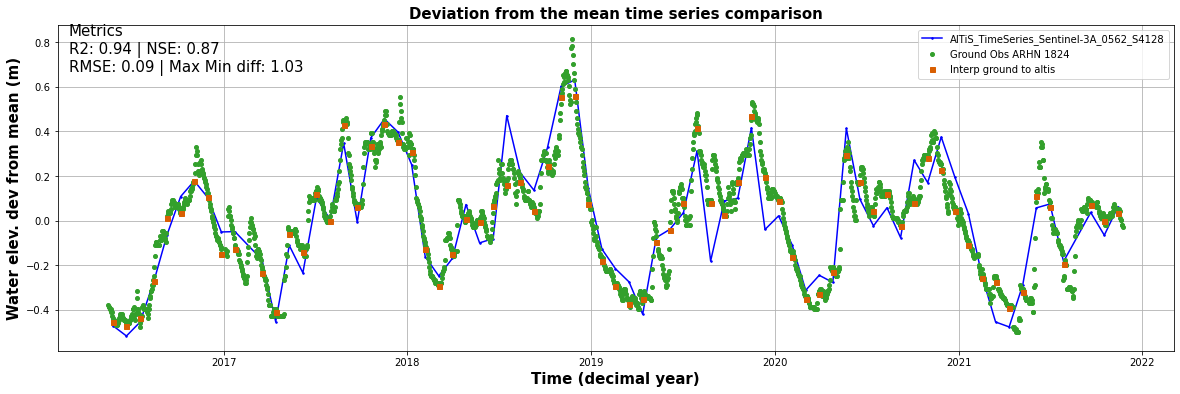

Station America/Argentina/Salta ncolgeoid: GEOID_01_MEDIAN 2028 ground_st: True df_altis: (77, 8)


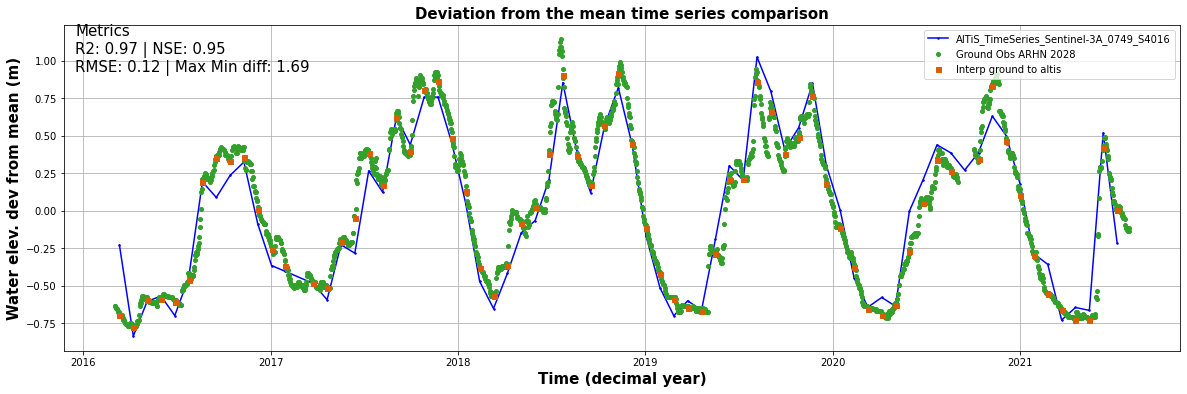

Station America/Argentina/Salta ncolgeoid: GEOID_EIGEN6C4D_MEDIAN 2028 ground_st: True df_altis: (104, 8)


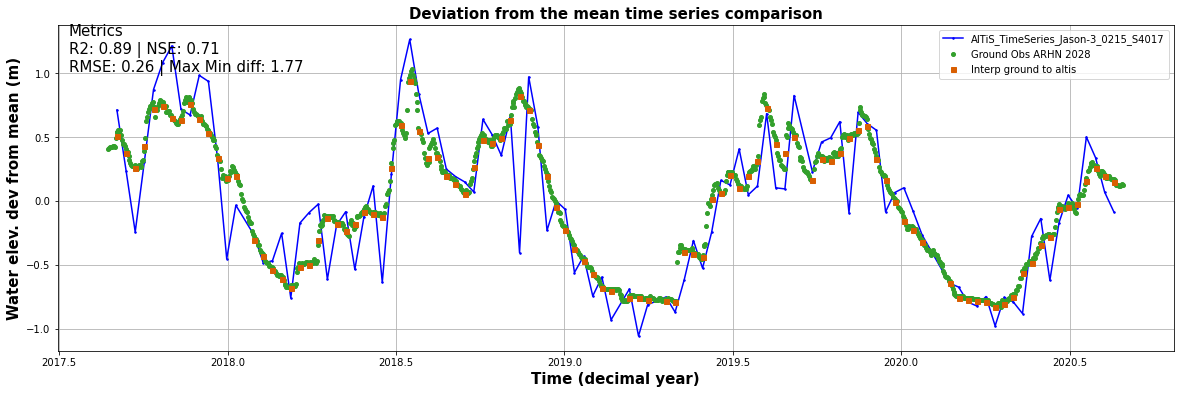

Station America/Argentina/Salta ncolgeoid: GEOID_MEDIAN 2028 ground_st: True df_altis: (157, 8)


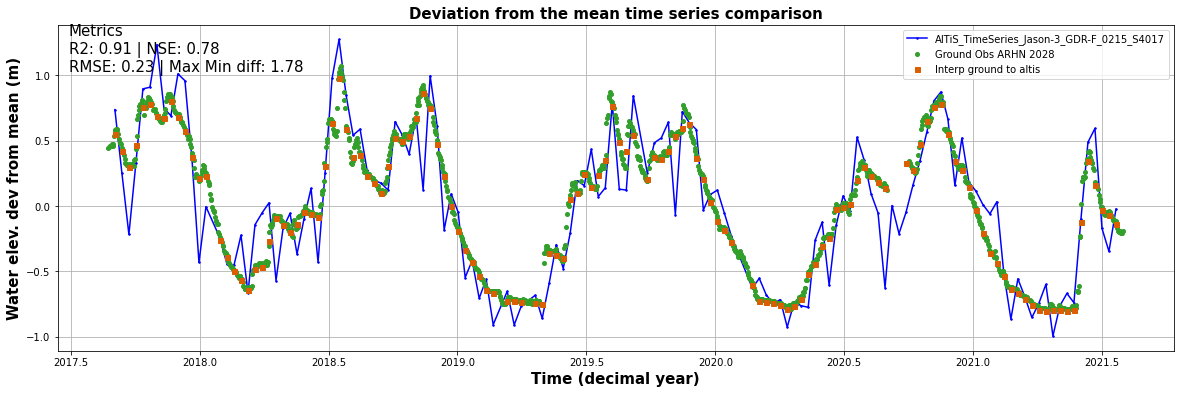

Station America/Argentina/Catamarca ncolgeoid: GEOID_01_MEDIAN 2234 ground_st: True df_altis: (76, 8)


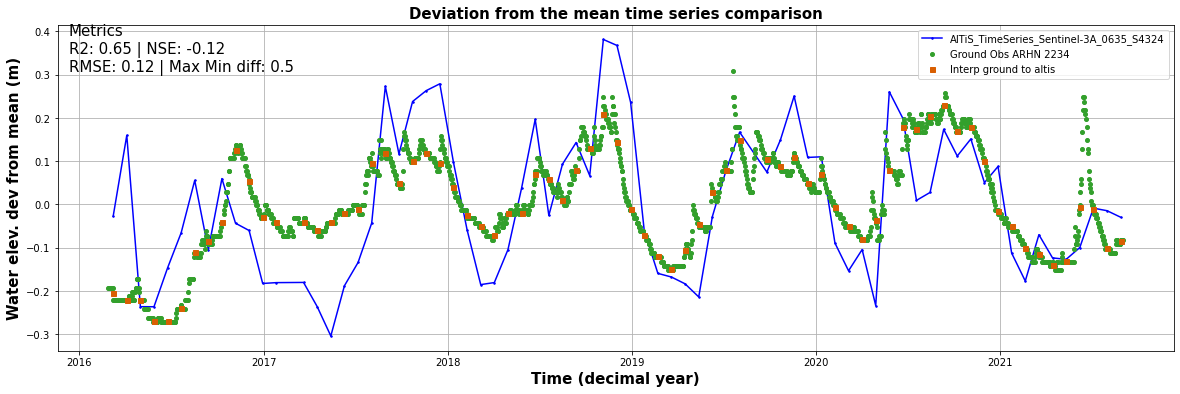

Station America/Argentina/Catamarca ncolgeoid: GEOID_01_MEDIAN 2234 ground_st: True df_altis: (75, 8)


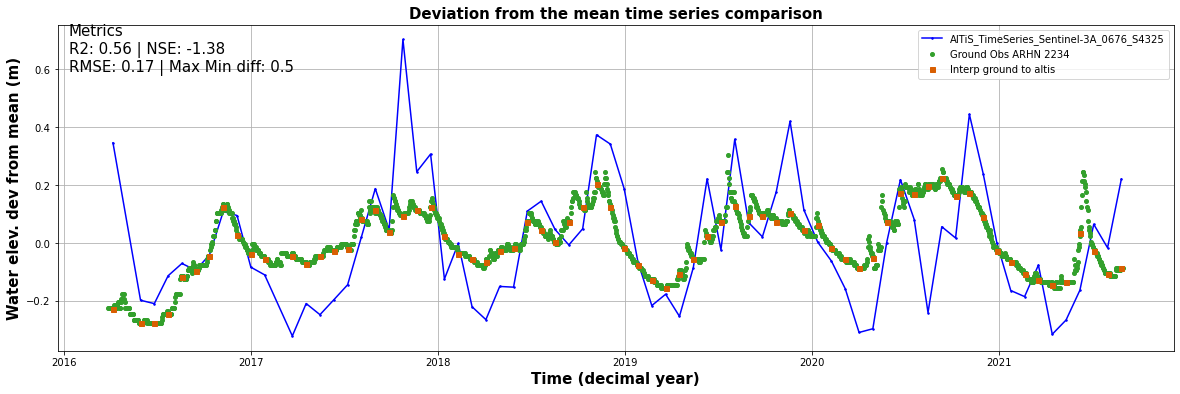

Station America/Argentina/Catamarca ncolgeoid: GEOID_01_MEDIAN 2316 ground_st: True df_altis: (41, 8)


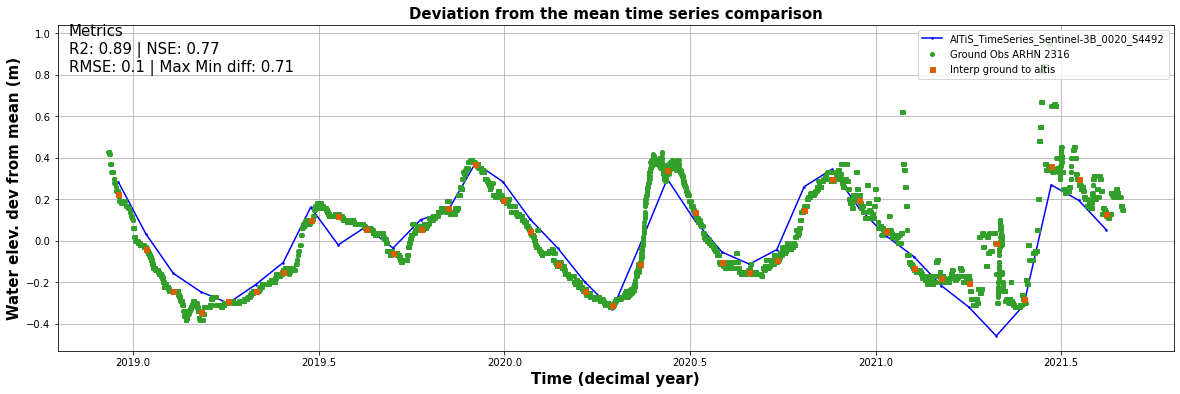

Station America/New_York ncolgeoid: GEOID_01_MEDIAN BTN2 ground_st: True df_altis: (41, 8)


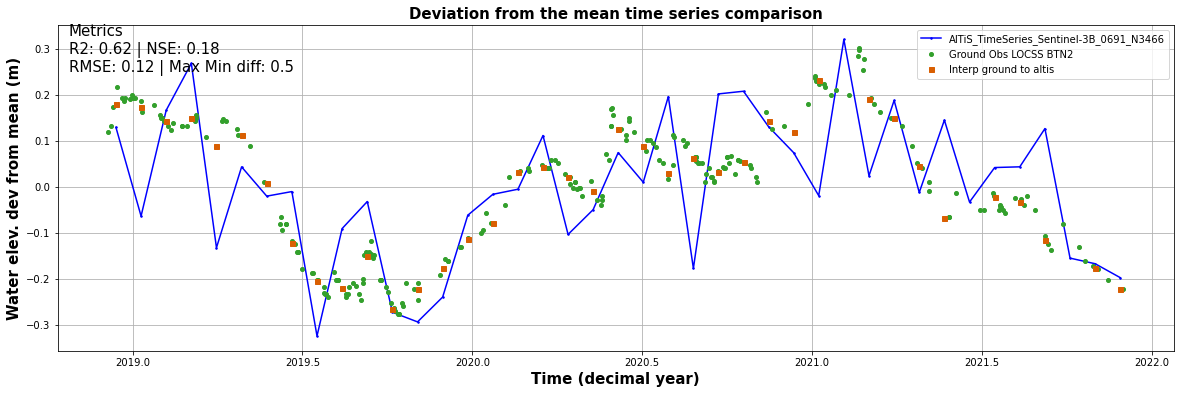

Station America/New_York ncolgeoid: GEOID_01_MEDIAN CFN2 ground_st: True df_altis: (61, 8)


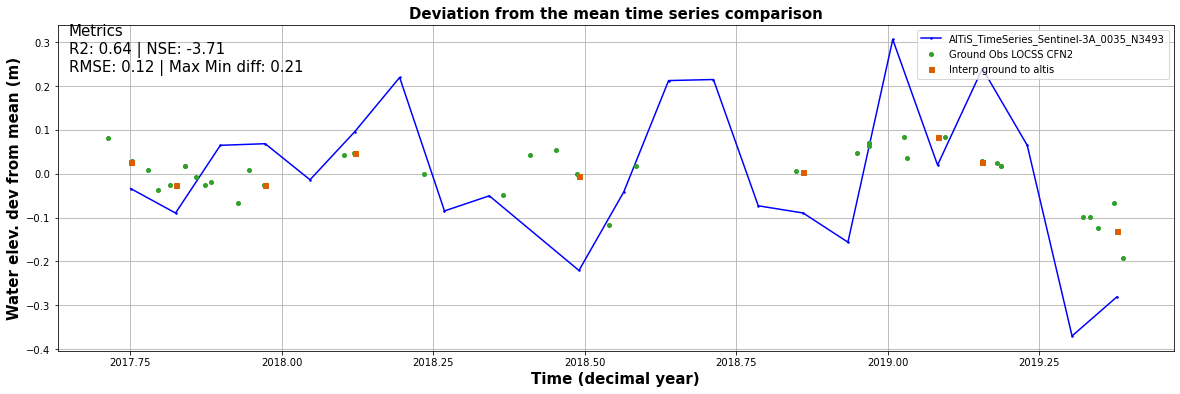

Station America/Edmonton ncolgeoid: GEOID_01_MEDIAN HMT2 ground_st: True df_altis: (73, 8)


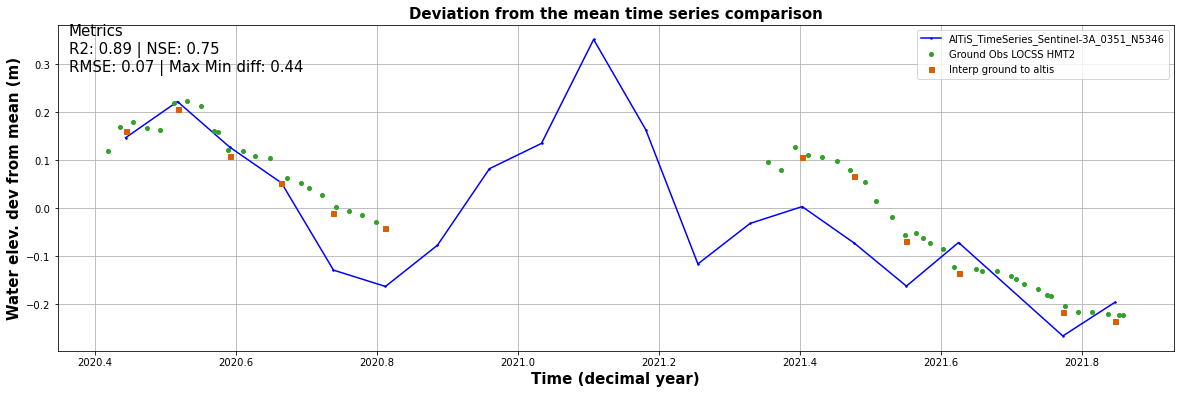

Station Asia/Dhaka ncolgeoid: GEOID_01_MEDIAN KHB2 ground_st: True df_altis: (67, 8)


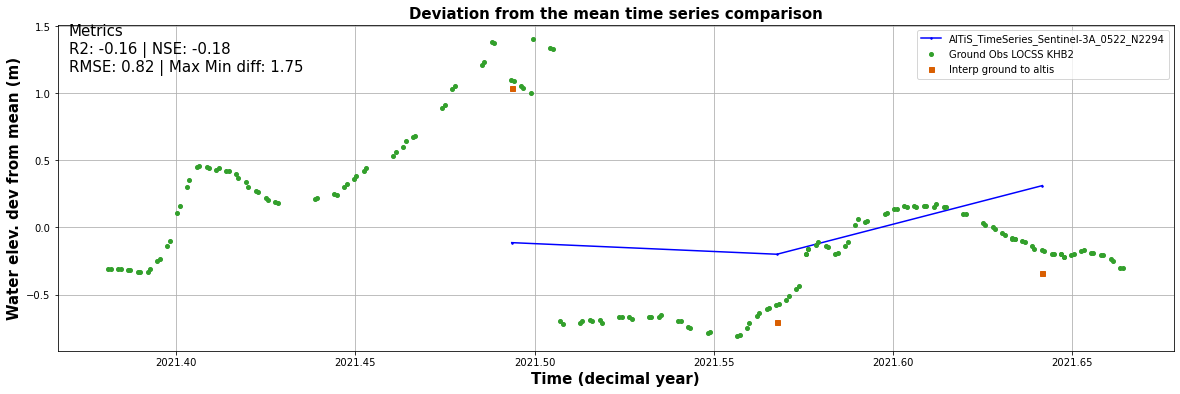

Station America/New_York ncolgeoid: GEOID_01_MEDIAN PHN2 ground_st: True df_altis: (78, 8)


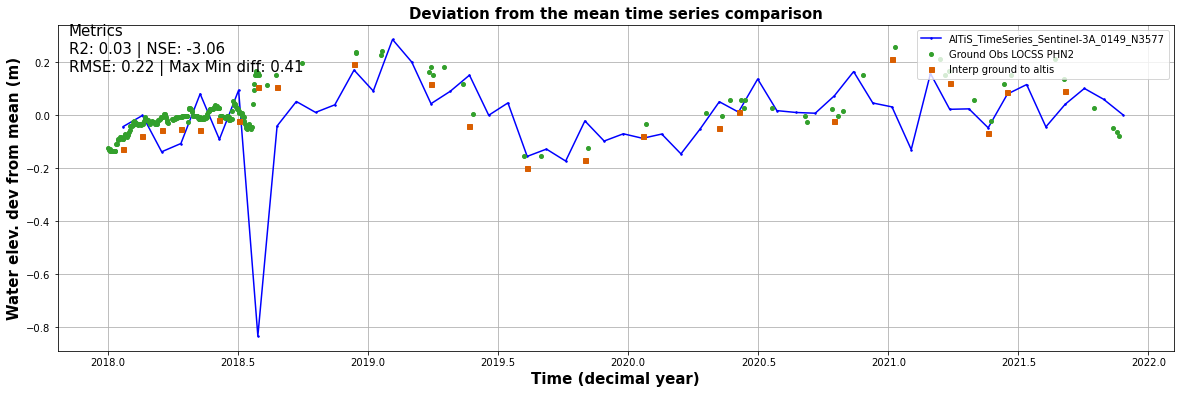

Station America/Chicago ncolgeoid: GEOID_01_MEDIAN QUL2 ground_st: True df_altis: (13, 8)


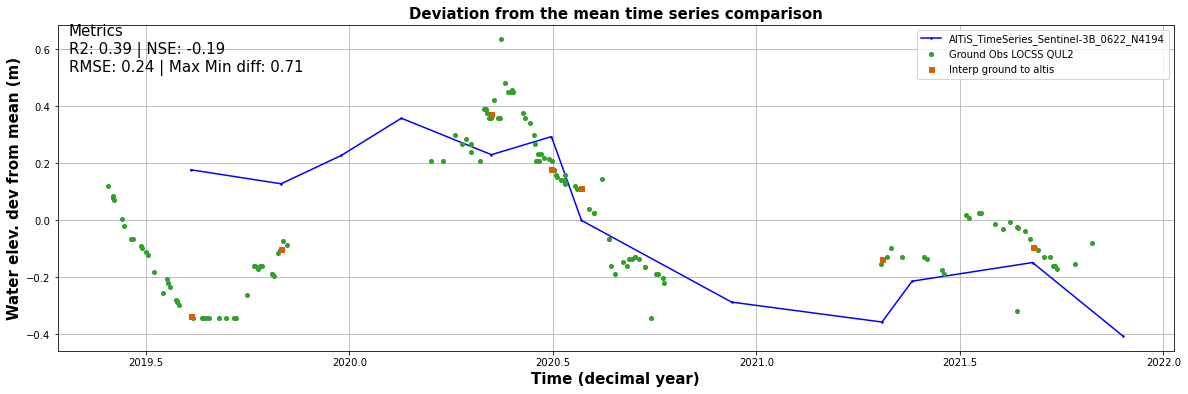

Station America/Los_Angeles ncolgeoid: GEOID_01_MEDIAN RAW2 ground_st: True df_altis: (22, 8)


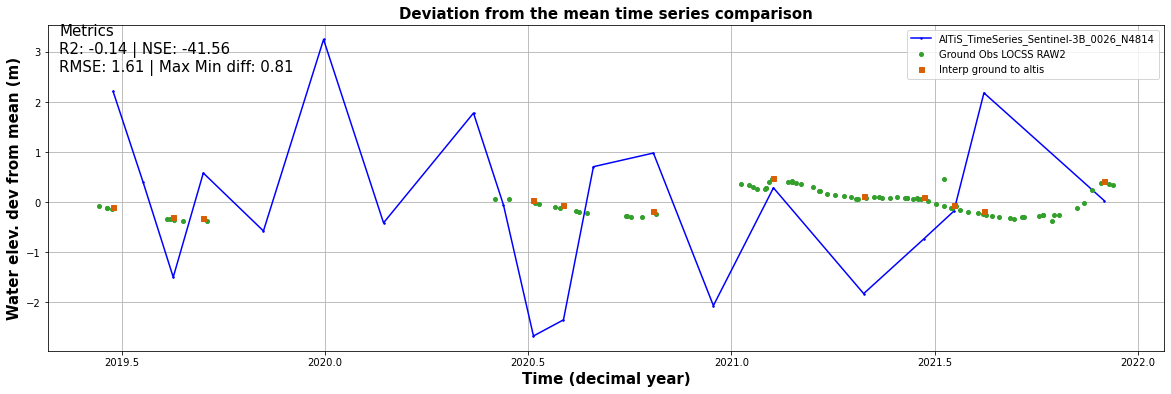

Station America/Los_Angeles ncolgeoid: GEOID_01_MEDIAN SAW2 ground_st: True df_altis: (75, 8)


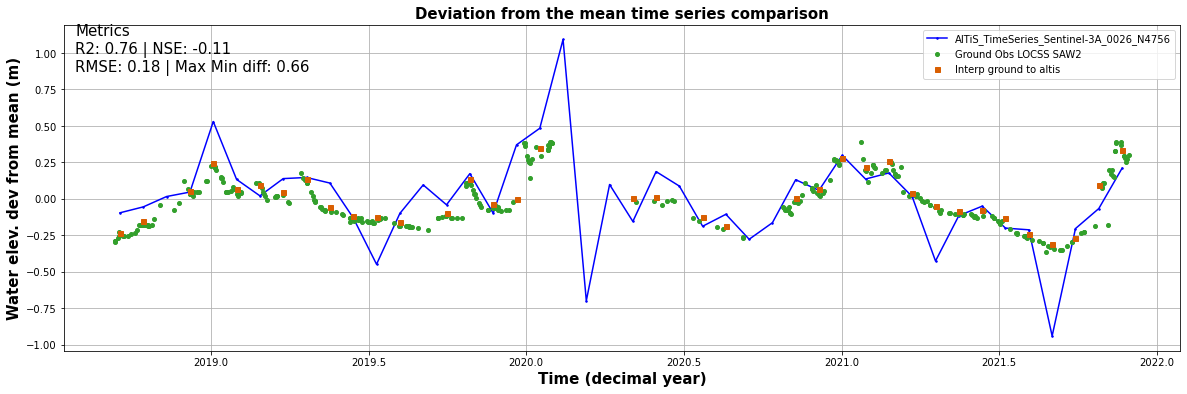

Station Antarctica/McMurdo ncolgeoid: GEOID_01_MEDIAN SLL2 ground_st: True df_altis: (34, 8)


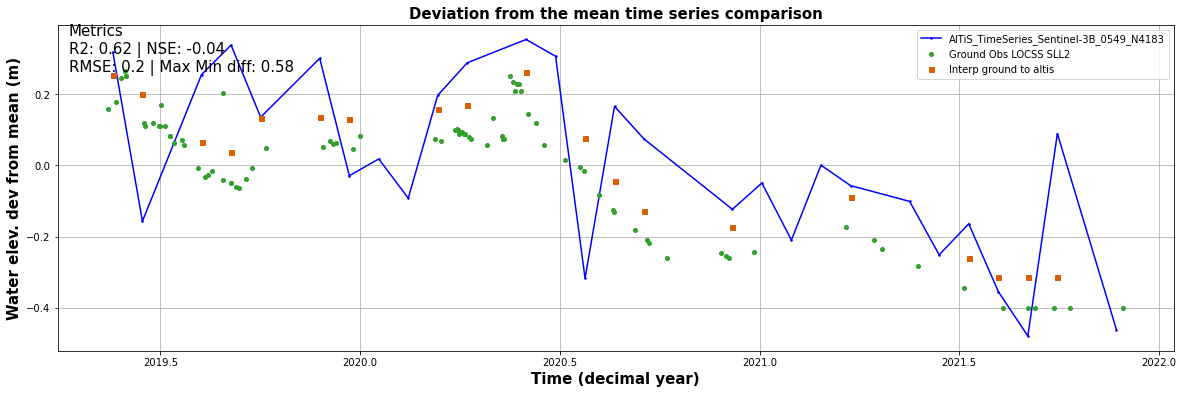

Station America/Los_Angeles ncolgeoid: GEOID_01_MEDIAN WEW2 ground_st: True df_altis: (76, 8)


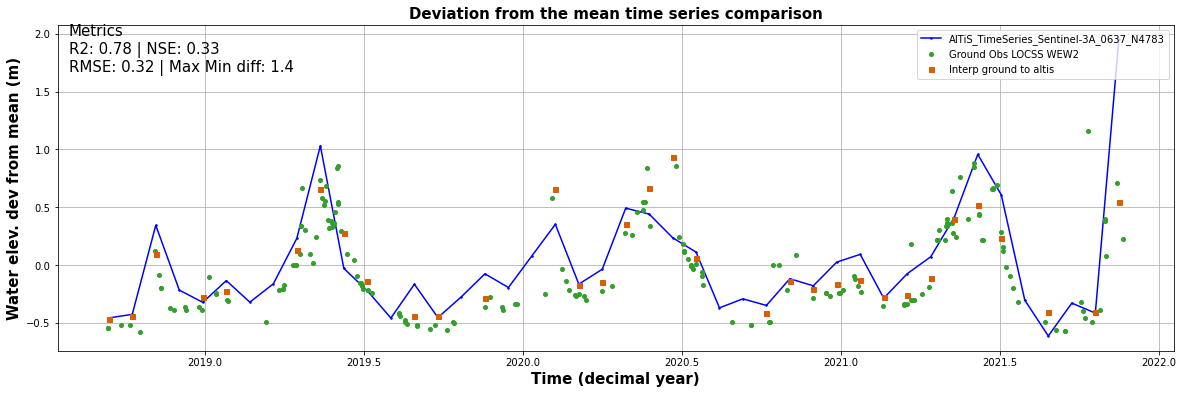

Station Antarctica/McMurdo ncolgeoid: GEOID_01_MEDIAN YSL2 ground_st: True df_altis: (26, 8)


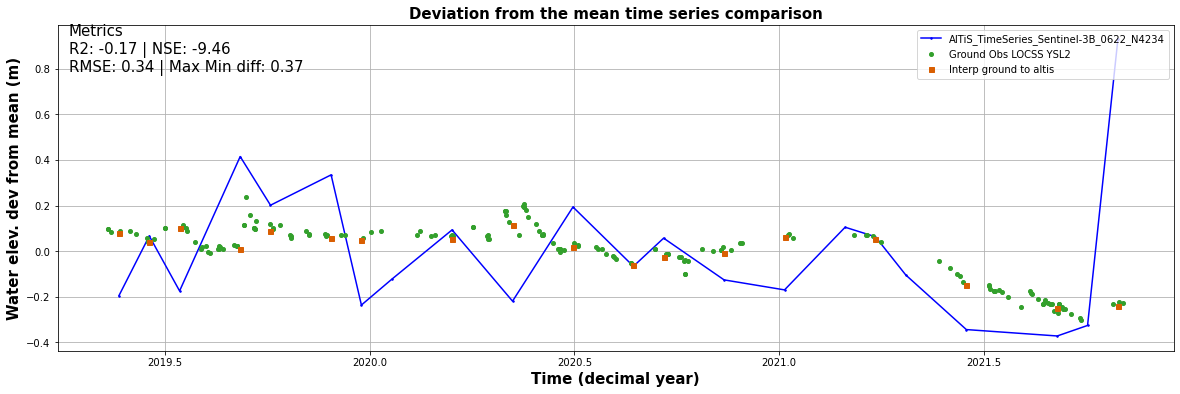

Station Asia/Dhaka ncolgeoid: GEOID_01_MEDIAN TAB2 ground_st: True df_altis: (76, 8)


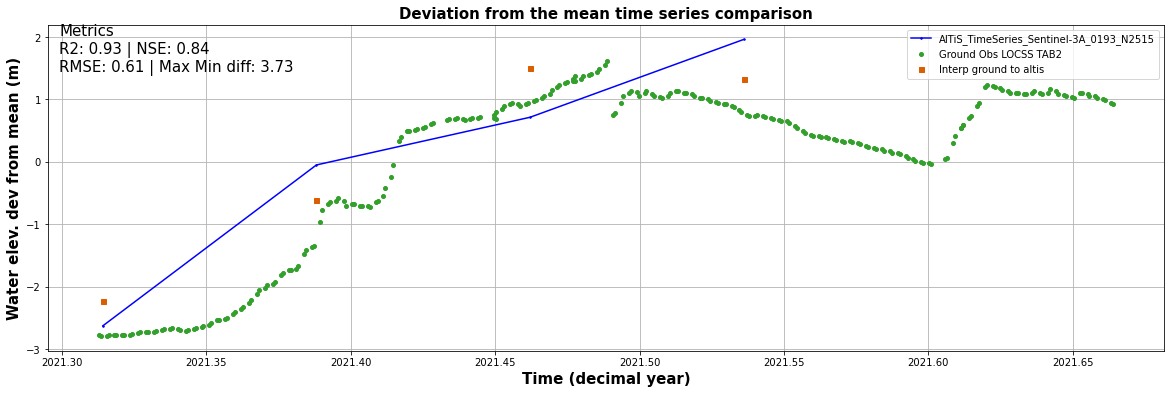

Station Asia/Dhaka ncolgeoid: GEOID_01_MEDIAN MAB2 ground_st: True df_altis: (76, 8)


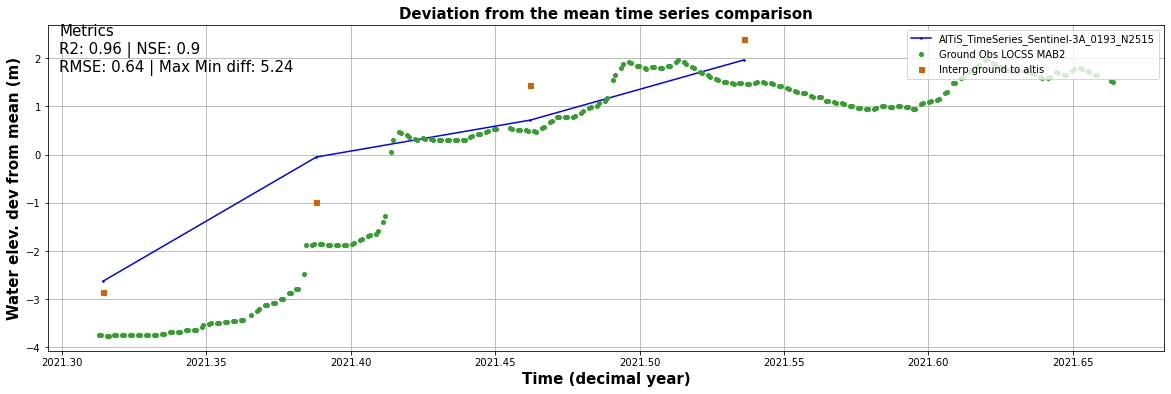

Station America/Sao_Paulo ncolgeoid: GEOID_01_MEDIAN 19060 ground_st: True df_altis: (52, 8)


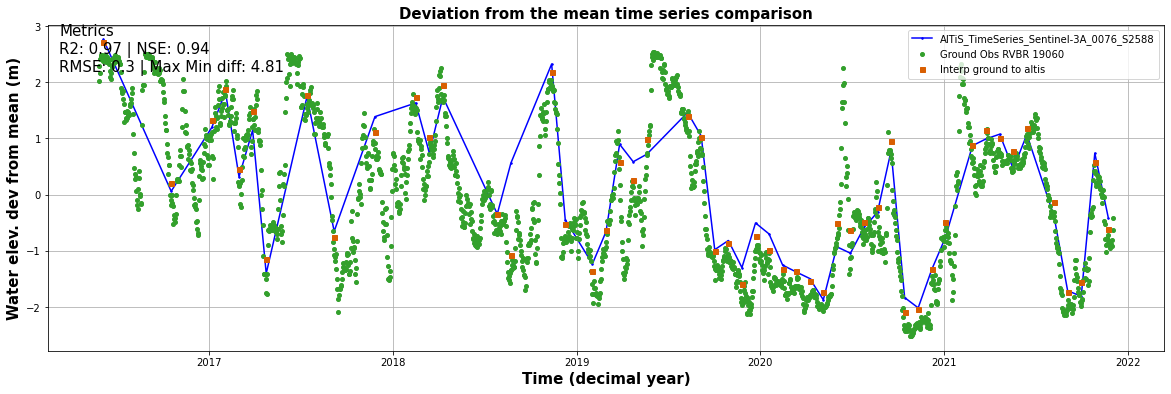

Station America/Sao_Paulo ncolgeoid: GEOID_EIGEN6C4D_MEDIAN 19060 ground_st: True df_altis: (106, 8)


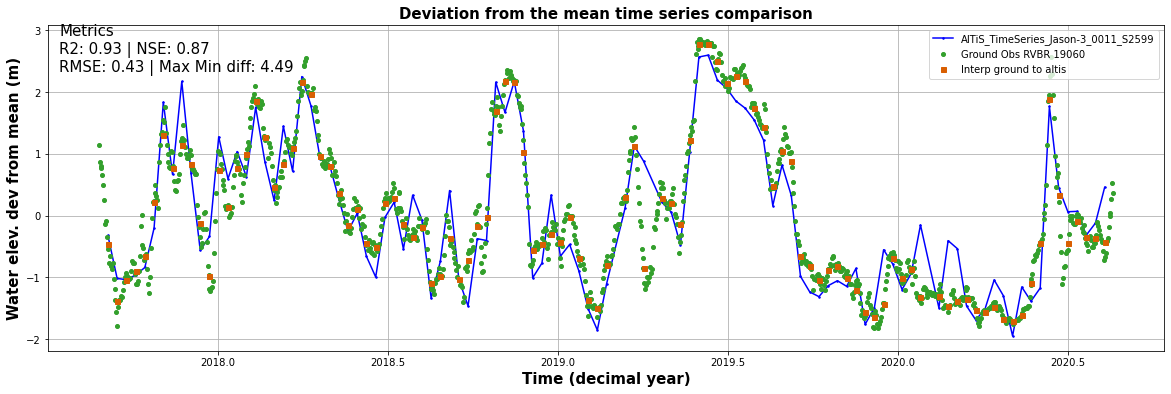

Station America/Maceio ncolgeoid: GEOID_01_MEDIAN 19126 ground_st: True df_altis: (37, 8)


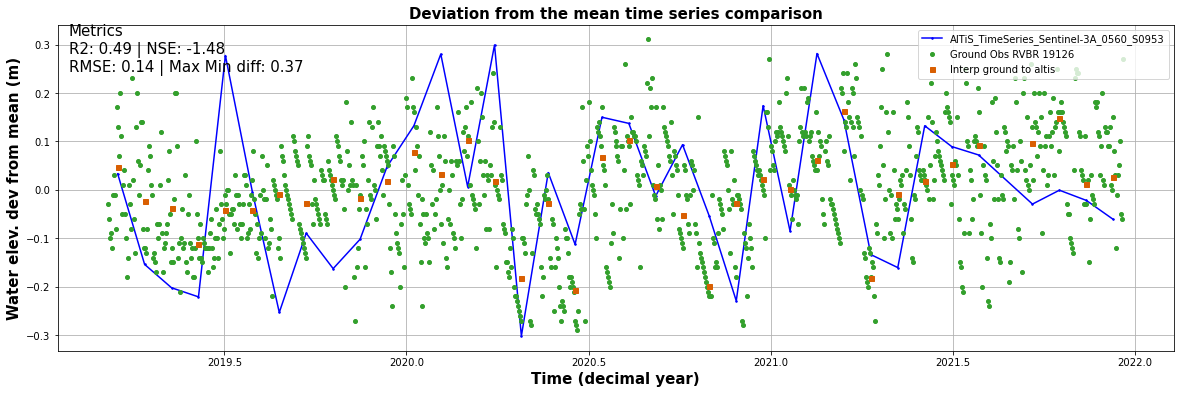

Error: no column geoid_01_median in ../data/alti_timeseries/AlTiS_TimeSeries_Sentinel-3A_0190_S2751.csv
Station America/Sao_Paulo ncolgeoid: GEOID_01_MEDIAN 19069 ground_st: True df_altis: (56, 8)


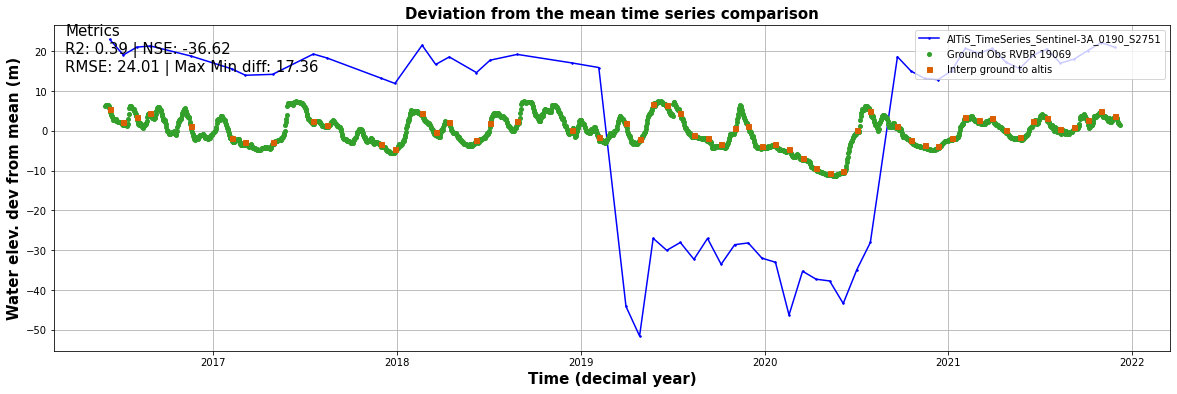

Station America/Chicago ncolgeoid: GEOID_01_MEDIAN 2464800 ground_st: True df_altis: (78, 8)


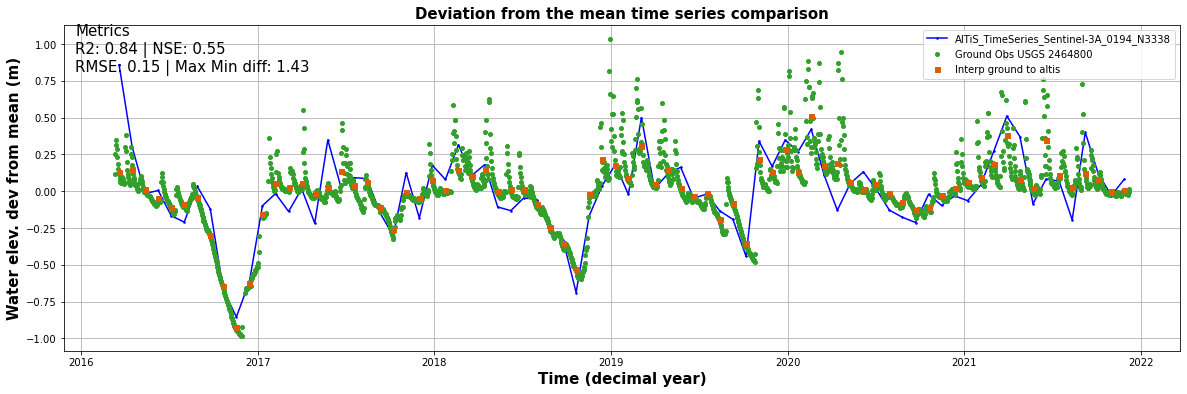

Station America/Chicago ncolgeoid: GEOID_01_MEDIAN 6604000 ground_st: True df_altis: (41, 8)


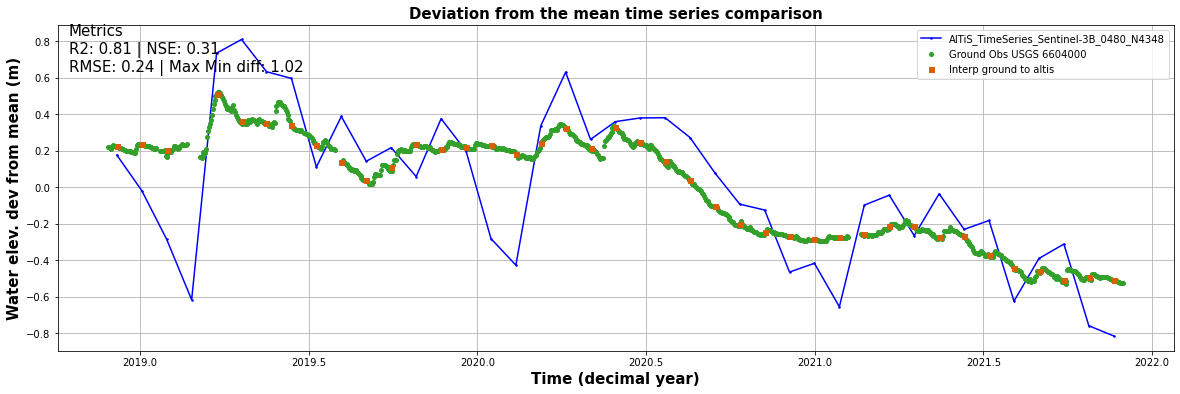

Station America/Chicago ncolgeoid: GEOID_01_MEDIAN 6903880 ground_st: True df_altis: (77, 8)


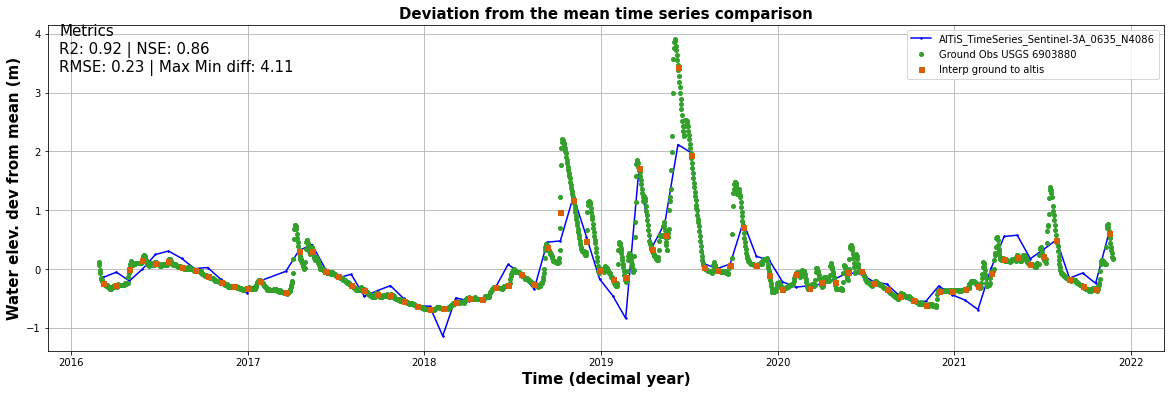

In [37]:
# Interpolate with 


path= '../data/alti_timeseries/lonlat_vs_altis_ed.csv'
lon_fd='lon'
lat_fd='lat'

altis_csv=pd.read_csv(path)
#Add the time_zone to each coordinate 
tf=TimezoneFinder()

altis_csv['tz']=altis_csv.apply(lambda x:tf.timezone_at(lng=x[lon_fd],lat=x[lat_fd]), axis=1)

#filter only altis time series with ground observations
altis_w_gts_csv=altis_csv.loc[altis_csv['station_id'].notna()]


#Read each file and convert it to dataframe
g_path='../data/alti_timeseries/'
time_fig=datetime.now().strftime("%Y%m%d_%H_%M")
path_name='../data/plots_'+time_fig+'/'

df_gts=df_ground_ts

st_fd='gauge_id'
st_date_fd='date'
altis_date_fd = 'date'  # Same value for Sentinel-3A/B
altis_height_fd = 'ice1_ku_SurfHeight_alti_median'  # Same value for Sentinel-3A/B
nodataalti=-9999

wse_ref='e'

i=1
df_final_altis=pd.DataFrame()
df_final_ground=pd.DataFrame()


for index,row in altis_w_gts_csv.iterrows():
    # print(row['station_id'])
    altis_name=row['altivs_nam']
    st_id=row['station_id']
    ncolgeoid=row['ncolgeoid']
    # Call every altis relative to the ellipsoide
    
    # is_Sentinel=altis_name.find('Sentinel-3')
    # if is_Sentinel!=-1:
    if ncolgeoid!='No':
        #Call the function with geoid field and wse_type='e'
        df_altis, df_ground_st=open_match_station_altis(g_path,altis_name, st_fd, df_gts, st_id,altis_date_fd, altis_height_fd,
                                                        nodataalti,ncolgeoid=ncolgeoid,wse_ref=wse_ref)
    else:
        #Call the function with geoid field and wse_type='g'
        df_altis, df_ground_st=open_match_station_altis(g_path,altis_name, st_fd, df_gts, st_id,altis_date_fd, altis_height_fd, nodataalti)
    
    print('Station '+row['tz']+' ncolgeoid: '+str(ncolgeoid).upper(), st_id+' ground_st: '+str(not df_ground_st.empty)+' df_altis: '+str(df_altis.shape))
    # print(df_altis.columns)
    if not df_ground_st.empty:
        # print('df_altis\n', df_altis.head(3))
        # print('df_ground_st '+st_id+'\n', df_ground_st.head(3))
        df_altis['ground_st_1']=st_id
        #Convert time in df_gts_st to UTC
        source=df_ground_st['source'].iloc[0]

        df_ground_st['date_utc']=[timezone(row['tz']).localize(date).astimezone(utc.zone) for date in df_ground_st[st_date_fd]]
        
        #print('\nBefore: '+st_id+'\n', df_ground_st[[st_date_fd,'date_utc','decimal_y']].head())
        df_ground_st['altis_d_1']=altis_name


        (df_altis_c, df_ground_c)=get_common_period(df_ts1=df_altis, df_ts2=df_ground_st, 
                                                    date_ts1_fd=altis_date_fd, date_ts2_fd='date_utc', delta_days=True, ndays=10)
        
        if source=='USGS':
            df_ground_c=get_date_time_cols(df_ground_c, 'date_utc', has_hour=False)
        else:
            df_ground_c=get_date_time_cols(df_ground_c, 'date_utc', has_hour=True)
        #print('\nAfter: '+st_id+'\n', df_ground_st[[st_date_fd,'date_utc','decimal_y']].head())
        df_ground_c=df_ground_c.sort_values(by=['decimal_y'])
        df_altis_c=df_altis_c.sort_values(by=['decimal_y'])
        # print(df_altis_c.head())
        delta=5
        median_fd='median_d_'+str(delta)
        mean_fd='mean_d_'+str(delta)
        std_fd='std_d_'+str(delta)
        count_fd='count_d_'+str(delta)

        df_altis_c[[median_fd,mean_fd, std_fd,count_fd]]=df_altis_c.apply(lambda x: moving_window_around_date(df_ground_c,
                                                                                                              x[altis_date_fd],
                                                                                                              delta,
                                                                                                              'height',
                                                                                                              'date_utc'), axis=1).apply(pd.Series)

        corr_alti_insi, ns_alti_insi, rmse_alti_insi, ampl_insi=get_comp_metrics(ts_obs=df_altis_c['height'].to_numpy(),ts_est=df_altis_c[median_fd].to_numpy())
        
        #Create a output dataframe with the metrics
        df_comp_metrics=(corr_alti_insi, ns_alti_insi, rmse_alti_insi, ampl_insi).apply(pd.Series)
        df_comp_metrics['station']=st_id
        df_comp_metrics['altis']=altis_name
        df_comp_metrics['source']=source
        df_comp_metrics['method']='Moving Window'
        
        error_m_text='\nR2: '+str(np.round(corr_alti_insi, decimals=2))+' | '+\
        'NSE: '+str(np.round(ns_alti_insi,decimals=2))+'\n'+\
        'RMSE: '+str(np.round(rmse_alti_insi,decimals=2))+' | '+\
        'Max Min diff: '+str(np.round(ampl_insi,decimals=2))+'\n'

        labels=altis_name
        labelg='Ground Obs '+source+' '+st_id
        labeli='Interp ground to altis'

        output_f=path_name

        dfs=df_altis_c
        dfg=df_ground_c
        # dic_intp={'decimal_y':df_altis_plot['decimal_y'].to_numpy(), 'height':inh_2_altidy}

        dfi=df_altis_c[['decimal_y',median_fd]].copy()#pd.DataFrame(dic_intp)
        dfi=dfi.rename(columns={median_fd:'height'})
        date_plot_fd='decimal_y'
        height_plot_fd='height'
        nfig=i
        
        p=plot_dev_mean(nfig,dfs, dfg, dfi, source, st_id, altis_name, date_plot_fd, height_plot_fd, labels, labelg, labeli, error_m_text, output_f=None)
        p.show()
        p.close()
    
        
        i=i+1
        
        
        
    
    #['gauge_id','source'
    
# def open_match__plot_station_altis(g_path,altis_name, st_id, df_gts, altis_date_fd, altis_height_fd, nodataalti=-9999):


In [6]:
# pd.datetime(
from datetime import datetime
#.apply(str).info()#head()
df_ground_st

gauge_id source    decimal_y  height                date  year  month  \
0        1824   ARHN  2000.000797    1.26 2000-01-01 07:00:00  2000      1   
1        1824   ARHN  2000.003529    1.26 2000-01-02 07:00:00  2000      1   
2        1824   ARHN  2000.006261    1.26 2000-01-03 07:00:00  2000      1   
3        1824   ARHN  2000.008994    1.25 2000-01-04 07:00:00  2000      1   
4        1824   ARHN  2000.011726    1.23 2000-01-05 07:00:00  2000      1   
...       ...    ...          ...     ...                 ...   ...    ...   
8032     1824   ARHN  2022.072032    0.96 2022-01-27 07:00:00  2022      1   
8033     1824   ARHN  2022.074772    0.96 2022-01-28 07:00:00  2022      1   
8034     1824   ARHN  2022.077511    0.95 2022-01-29 07:00:00  2022      1   
8035     1824   ARHN  2022.080251    0.94 2022-01-30 07:00:00  2022      1   
8036     1824   ARHN  2022.082991    0.94 2022-01-31 07:00:00  2022      1   

      day  hour                  date_utc  \
0       1     7 2000-01-01 10:00:00+00:00   
1       2     7 2000-01-02 10:00:00+00:00   
2       3     7 2000-01-03 10:00:00+00:00   
3       4     7 2000-01-04 10:00:00+00:00   
4       5     7 2000-01-05 10:00:00+00:00   
...   ...   ...                       ...   
8032   27     7 2022-01-27 10:00:00+00:00   
8033   28     7 2022-01-28 10:00:00+00:00   
8034   29     7 2022-01-29 10:00:00+00:00   
8035   30     7 2022-01-30 10:00:00+00:00   
8036   31     7 2022-01-31 10:00:00+00:00   

                                    altis_d_1  
0     AlTiS_TimeSeries_Sentinel-3A_0562_S4128  
1     AlTiS_TimeSeries_Sentinel-3A_0562_S4128  
2     AlTiS_TimeSeries_Sentinel-3A_0562_S4128  
3     AlTiS_TimeSeries_Sentinel-3A_0562_S4128  
4     AlTiS_TimeSeries_Sentinel-3A_0562_S4128  
...                                       ...  
8032  AlTiS_TimeSeries_Sentinel-3A_0562_S4128  
8033  AlTiS_TimeSeries_Sentinel-3A_0562_S4128  
8034  AlTiS_TimeSeries_Sentinel-3A_0562_S4128  
8035  AlTiS_TimeSeries_Sentinel-3A_0562_S4128  
8036  AlTiS_TimeSeries_Sentinel-3A_0562_S4128  

[8037 rows x 11 columns]

In [16]:
df_ground_st.columns

Index(['gauge_id', 'source', 'decimal_y', 'height', 'date', 'year', 'month',
       'day', 'hour', 'date_utc', 'altis_d_1'],
      dtype='object')

Station America/Argentina/Salta ncolgeoid: GEOID_01_MEDIAN 1824 ground_st: True df_altis: (73, 7)

Altis_min Ground_min:  [2016.3977971311476, 2000.0011384335155]

Altis_max Ground_max:  [2021.8673820395738, 2022.0833333333333]
dimension ground altis (8037, 11) (73, 8)
dimension ground altis plot (1998, 11) (72, 8)


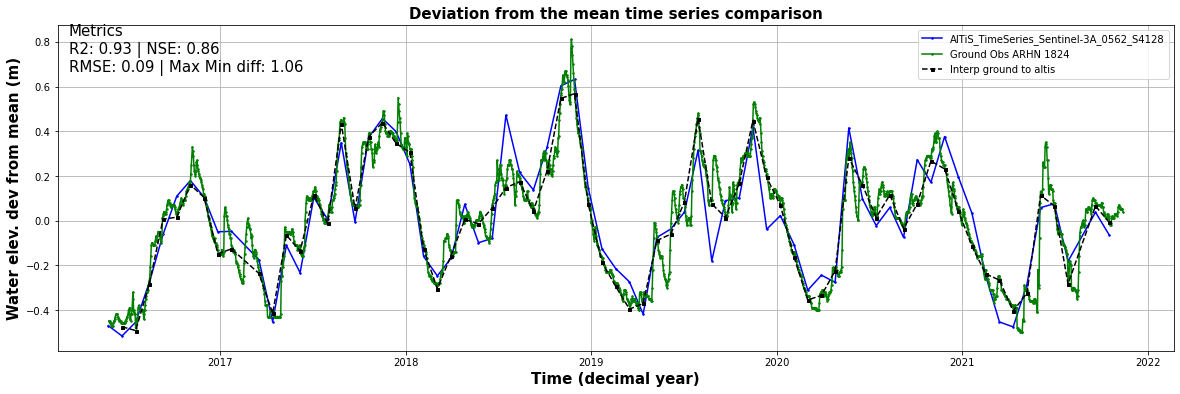

Station America/Argentina/Salta ncolgeoid: GEOID_01_MEDIAN 2028 ground_st: True df_altis: (77, 7)

Altis_min Ground_min:  [2016.1943571645415, 1969.1448630136986]

Altis_max Ground_max:  [2021.8853025114156, 2021.5801369863013]
dimension ground altis (31001, 11) (77, 8)
dimension ground altis plot (1924, 11) (72, 8)


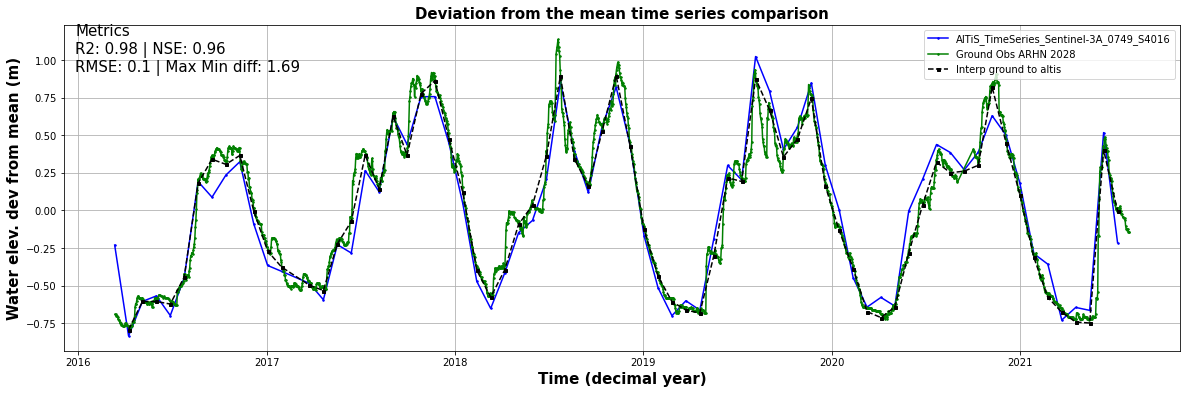

Station America/Argentina/Salta ncolgeoid: GEOID_EIGEN6C4D_MEDIAN 2028 ground_st: True df_altis: (104, 7)

Altis_min Ground_min:  [2017.671440258752, 1969.1448630136986]

Altis_max Ground_max:  [2020.6308230874317, 2021.5801369863013]
dimension ground altis (31001, 11) (104, 8)
dimension ground altis plot (1082, 11) (103, 8)


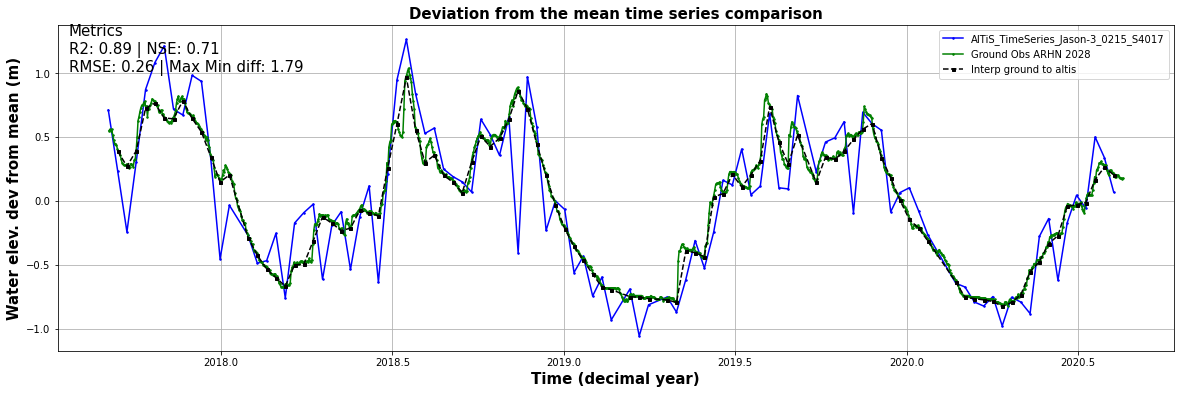

Station America/Argentina/Salta ncolgeoid: GEOID_MEDIAN 2028 ground_st: True df_altis: (157, 7)

Altis_min Ground_min:  [2017.671440258752, 1969.1448630136986]

Altis_max Ground_max:  [2022.0967827245054, 2021.5801369863013]
dimension ground altis (31001, 11) (157, 8)
dimension ground altis plot (1398, 11) (138, 8)


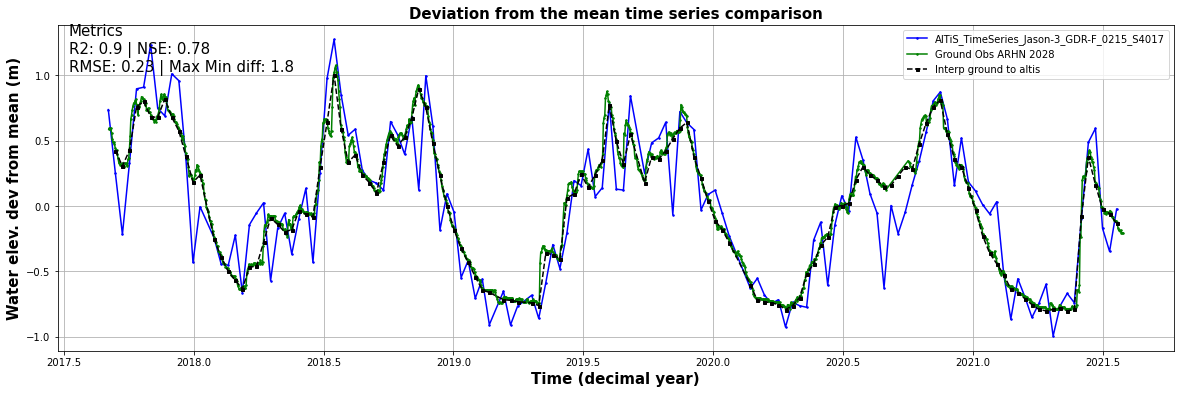

Station America/Argentina/Catamarca ncolgeoid: GEOID_01_MEDIAN 2234 ground_st: True df_altis: (76, 7)

Altis_min Ground_min:  [2016.1834357923497, 1948.165072859745]

Altis_max Ground_max:  [2021.8743493150685, 2021.6642694063928]
dimension ground altis (26584, 11) (76, 8)
dimension ground altis plot (2002, 11) (73, 8)


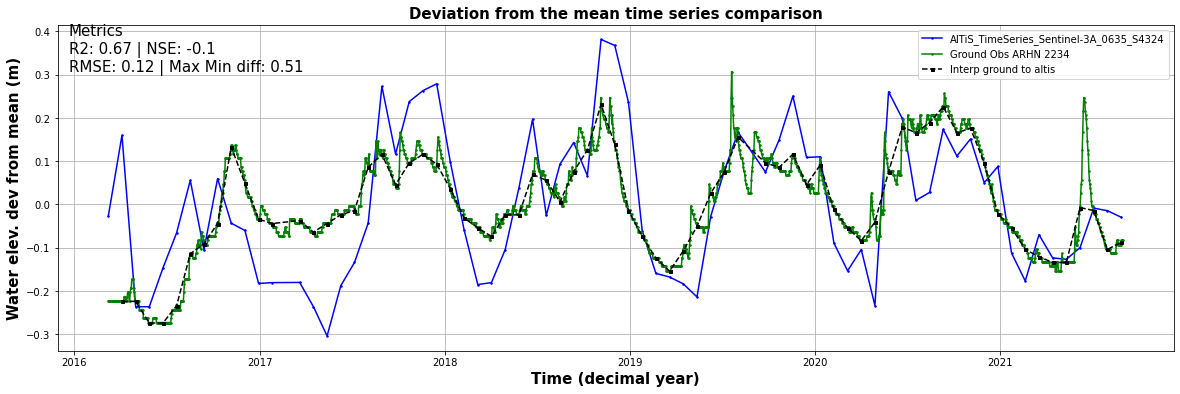

Station America/Argentina/Catamarca ncolgeoid: GEOID_01_MEDIAN 2234 ground_st: True df_altis: (75, 7)

Altis_min Ground_min:  [2016.261179417122, 1948.165072859745]

Altis_max Ground_max:  [2021.8783352359208, 2021.6642694063928]
dimension ground altis (26584, 11) (75, 8)
dimension ground altis plot (1973, 11) (72, 8)


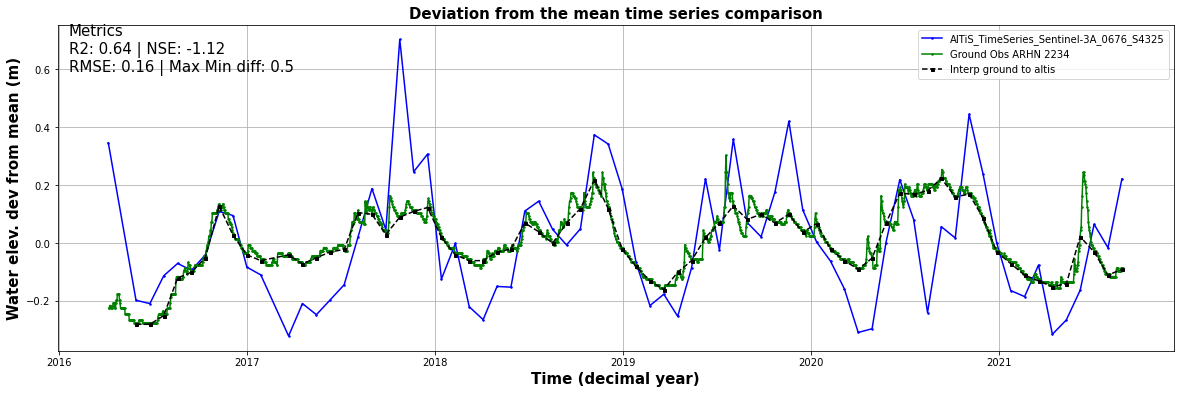

Station America/Argentina/Catamarca ncolgeoid: GEOID_01_MEDIAN 2316 ground_st: True df_altis: (41, 7)

Altis_min Ground_min:  [2018.9605232115678, 2011.0562785388129]

Altis_max Ground_max:  [2021.9166875951294, 2021.6658675799088]
dimension ground altis (38985, 11) (41, 8)
dimension ground altis plot (22084, 11) (37, 8)


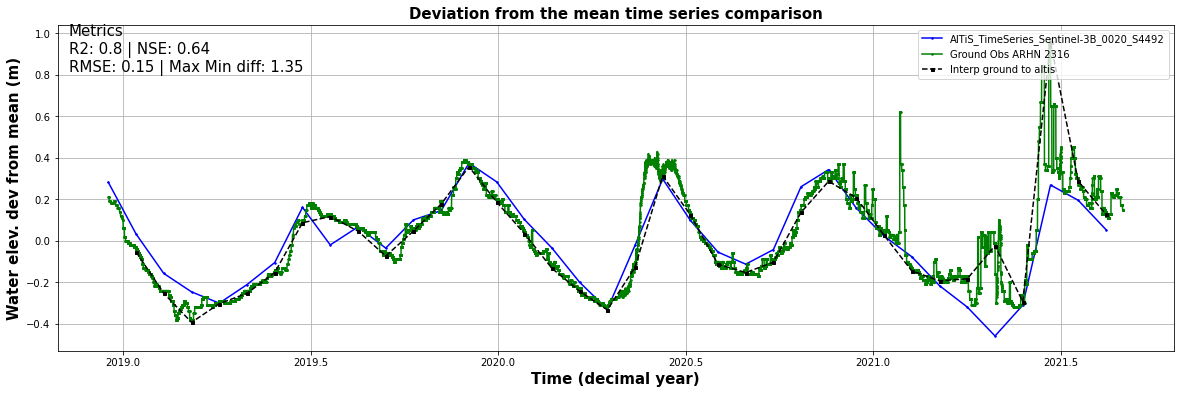

Station America/New_York ncolgeoid: GEOID_01_MEDIAN BTN2 ground_st: True df_altis: (41, 7)

Altis_min Ground_min:  [2018.9510064687975, 2017.2949771689498]

Altis_max Ground_max:  [2021.9071708523593, 2022.2020547945206]
dimension ground altis (536, 11) (41, 8)
dimension ground altis plot (246, 11) (40, 8)


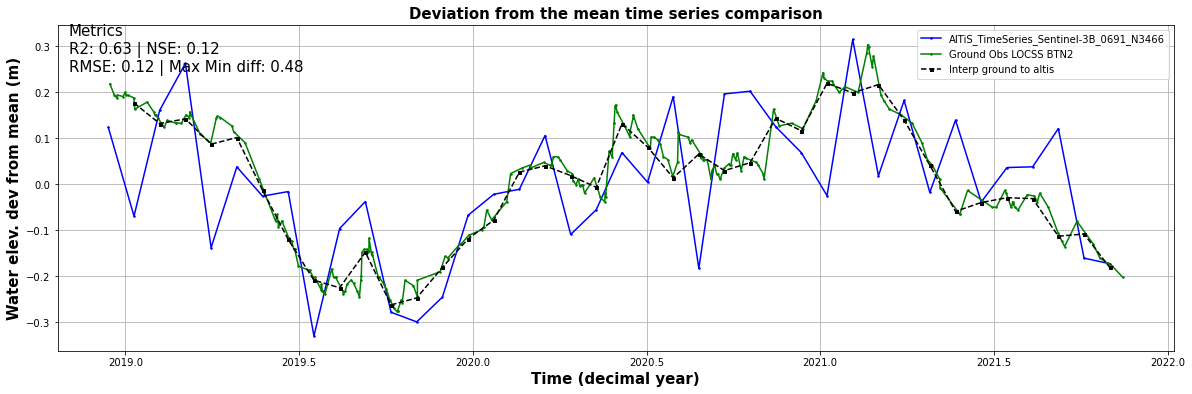

Station America/New_York ncolgeoid: GEOID_01_MEDIAN CFN2 ground_st: True df_altis: (61, 7)

Altis_min Ground_min:  [2016.199762826351, 2017.7140410958905]

Altis_max Ground_max:  [2021.8167503805175, 2019.3882420091325]
dimension ground altis (42, 11) (61, 8)
dimension ground altis plot (41, 11) (22, 8)


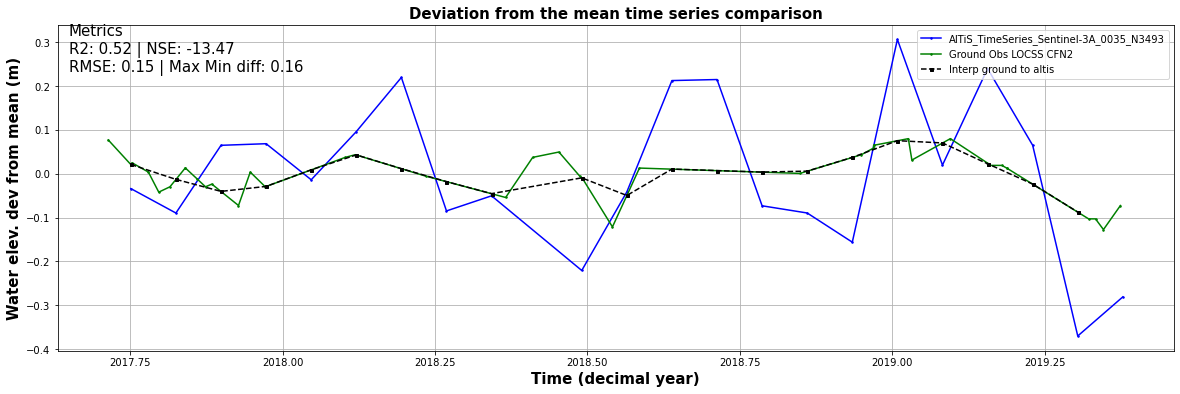

Station America/Edmonton ncolgeoid: GEOID_01_MEDIAN HMT2 ground_st: True df_altis: (73, 7)

Altis_min Ground_min:  [2016.3038194444443, 2020.4187158469945]

Altis_max Ground_max:  [2021.9210901826484, 2021.8583333333333]
dimension ground altis (53, 11) (73, 8)
dimension ground altis plot (52, 11) (19, 8)


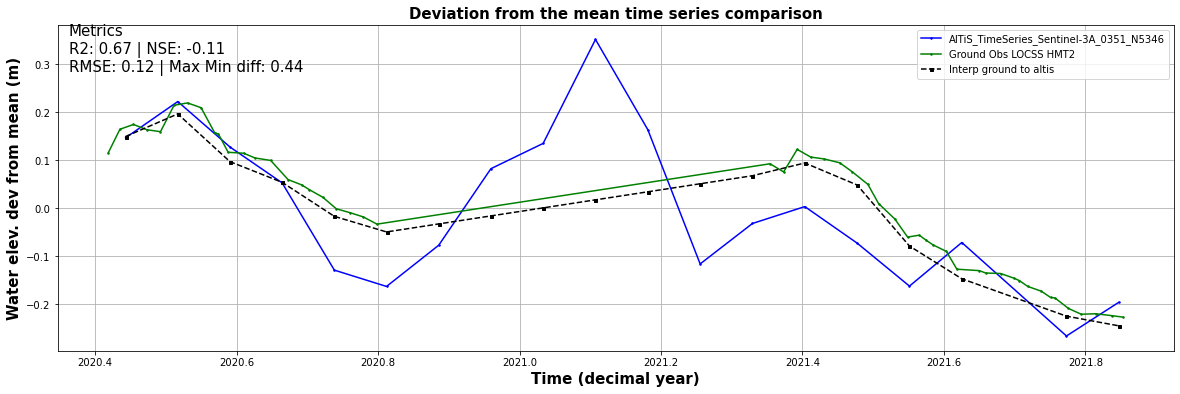

Station Asia/Dhaka ncolgeoid: GEOID_01_MEDIAN KHB2 ground_st: True df_altis: (67, 7)

Altis_min Ground_min:  [2016.1726187765635, 2021.3811643835616]

Altis_max Ground_max:  [2021.9374771689497, 2021.6640410958903]
dimension ground altis (170, 11) (67, 8)
dimension ground altis plot (169, 11) (3, 8)


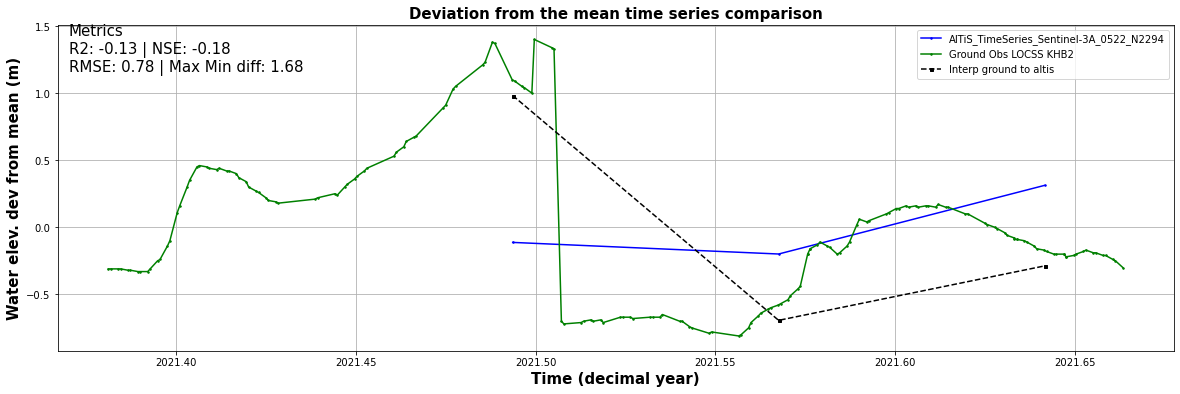

Station America/New_York ncolgeoid: GEOID_01_MEDIAN PHN2 ground_st: True df_altis: (78, 7)

Altis_min Ground_min:  [2016.210686095932, 2018.0005707762557]

Altis_max Ground_max:  [2021.9016742770168, 2022.2537671232876]
dimension ground altis (257, 11) (78, 8)
dimension ground altis plot (252, 11) (52, 8)


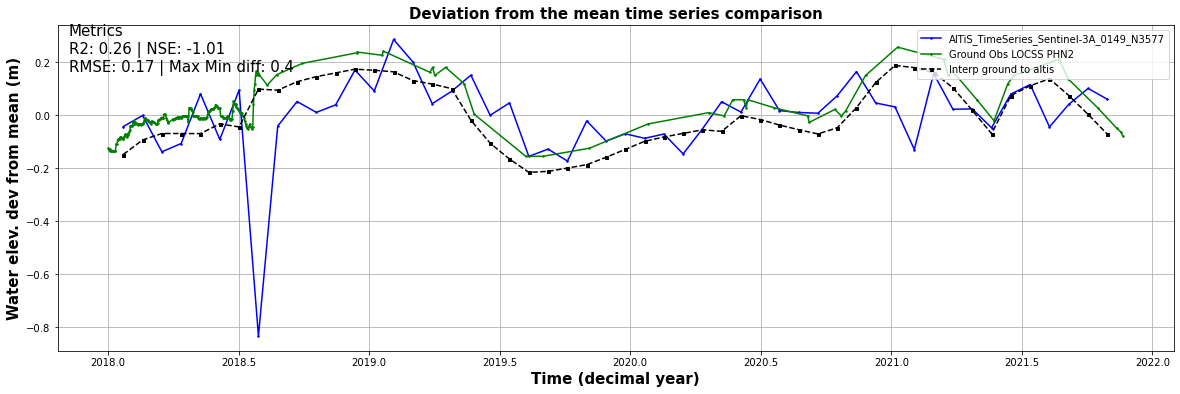

Station America/Chicago ncolgeoid: GEOID_01_MEDIAN QUL2 ground_st: True df_altis: (13, 7)

Altis_min Ground_min:  [2019.0183085996955, 2019.4074200913242]

Altis_max Ground_max:  [2021.900502283105, 2021.9551369863013]
dimension ground altis (145, 11) (13, 8)
dimension ground altis plot (143, 11) (11, 8)


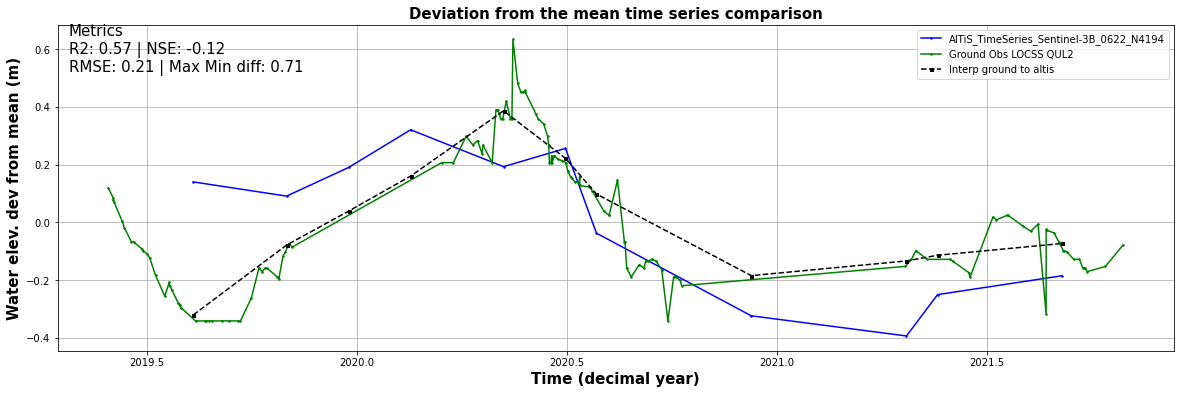

Station America/Los_Angeles ncolgeoid: GEOID_01_MEDIAN RAW2 ground_st: True df_altis: (22, 7)

Altis_min Ground_min:  [2019.0350209284627, 2019.4433789954337]

Altis_max Ground_max:  [2021.9172146118722, 2022.2429223744293]
dimension ground altis (113, 11) (22, 8)
dimension ground altis plot (90, 11) (19, 8)


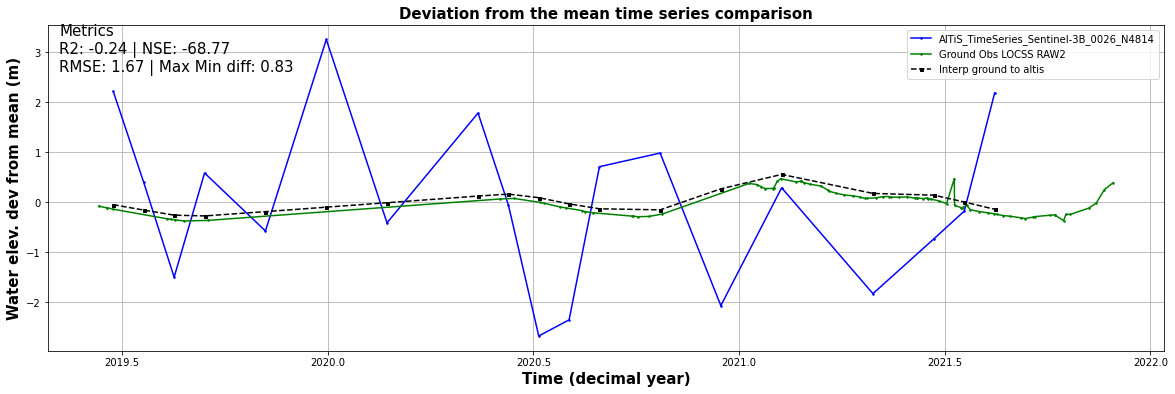

Station America/Los_Angeles ncolgeoid: GEOID_01_MEDIAN SAW2 ground_st: True df_altis: (75, 7)

Altis_min Ground_min:  [2016.2726282635094, 2018.6949771689497]

Altis_max Ground_max:  [2021.889813546423, 2022.254109589041]
dimension ground altis (397, 11) (75, 8)
dimension ground altis plot (348, 11) (43, 8)


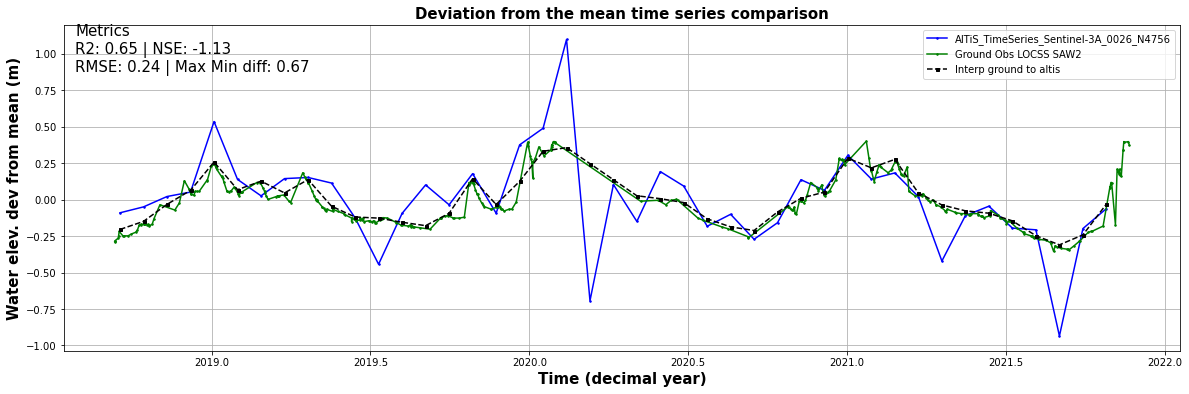

Station Antarctica/McMurdo ncolgeoid: GEOID_01_MEDIAN SLL2 ground_st: True df_altis: (34, 7)

Altis_min Ground_min:  [2018.937368721461, 2019.3697488584476]

Altis_max Ground_max:  [2021.893533105023, 2021.9535388127854]
dimension ground altis (88, 11) (34, 8)
dimension ground altis plot (86, 11) (27, 8)


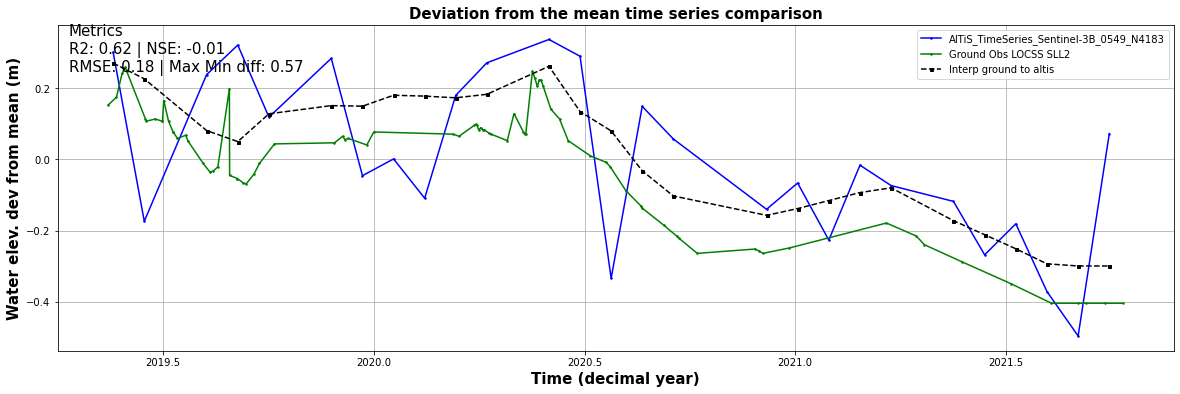

Station America/Los_Angeles ncolgeoid: GEOID_01_MEDIAN WEW2 ground_st: True df_altis: (76, 7)

Altis_min Ground_min:  [2016.2574453551913, 2018.6950913242008]

Altis_max Ground_max:  [2021.8745909436834, 2022.2546803652967]
dimension ground altis (213, 11) (76, 8)
dimension ground altis plot (201, 11) (43, 8)


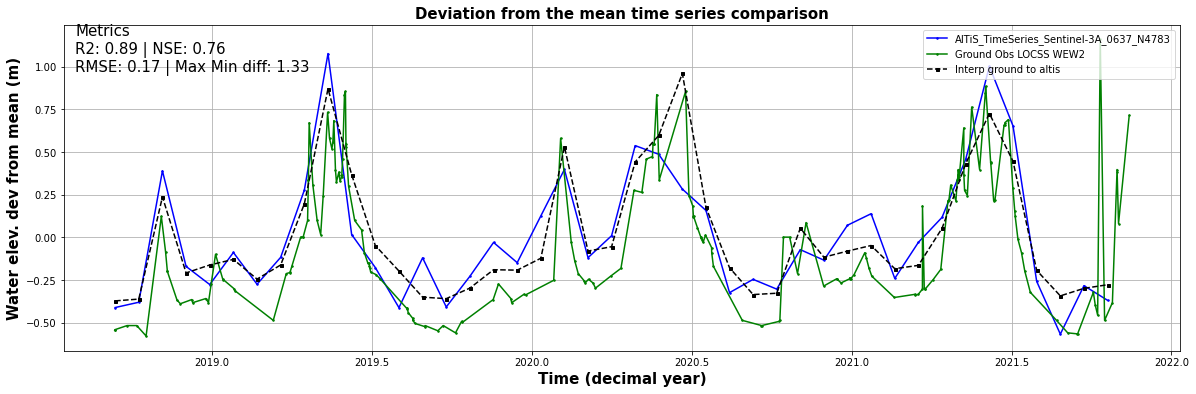

Station Antarctica/McMurdo ncolgeoid: GEOID_01_MEDIAN YSL2 ground_st: True df_altis: (26, 7)

Altis_min Ground_min:  [2018.944335996956, 2019.362100456621]

Altis_max Ground_max:  [2021.8265277777778, 2022.2527397260274]
dimension ground altis (185, 11) (26, 8)
dimension ground altis plot (175, 11) (21, 8)


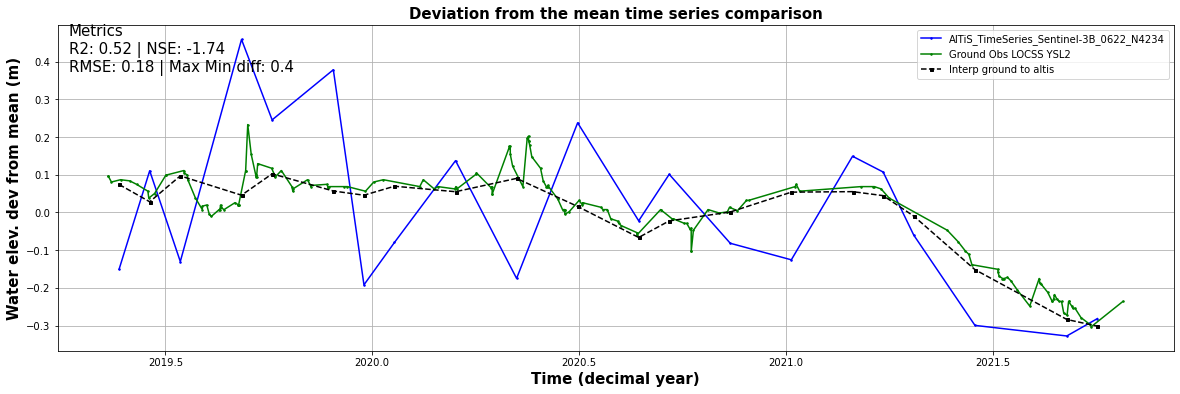

Station Asia/Dhaka ncolgeoid: GEOID_01_MEDIAN TAB2 ground_st: True df_altis: (76, 7)

Altis_min Ground_min:  [2016.21489640255, 2021.3126712328767]

Altis_max Ground_max:  [2021.9058961187216, 2021.6640410958903]
dimension ground altis (258, 11) (76, 8)
dimension ground altis plot (257, 11) (4, 8)


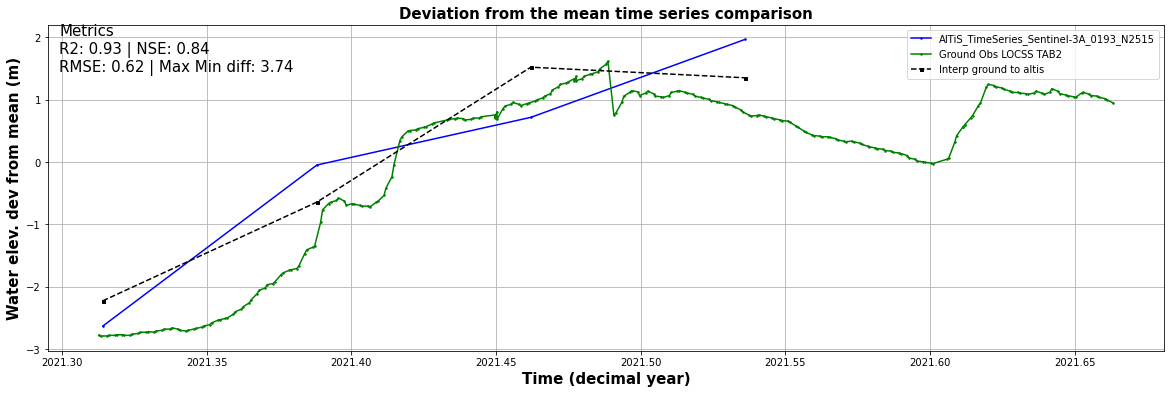

Station Asia/Dhaka ncolgeoid: GEOID_01_MEDIAN MAB2 ground_st: True df_altis: (76, 7)

Altis_min Ground_min:  [2016.21489640255, 2021.3126712328767]

Altis_max Ground_max:  [2021.9058961187216, 2021.6640410958903]
dimension ground altis (253, 11) (76, 8)
dimension ground altis plot (252, 11) (4, 8)


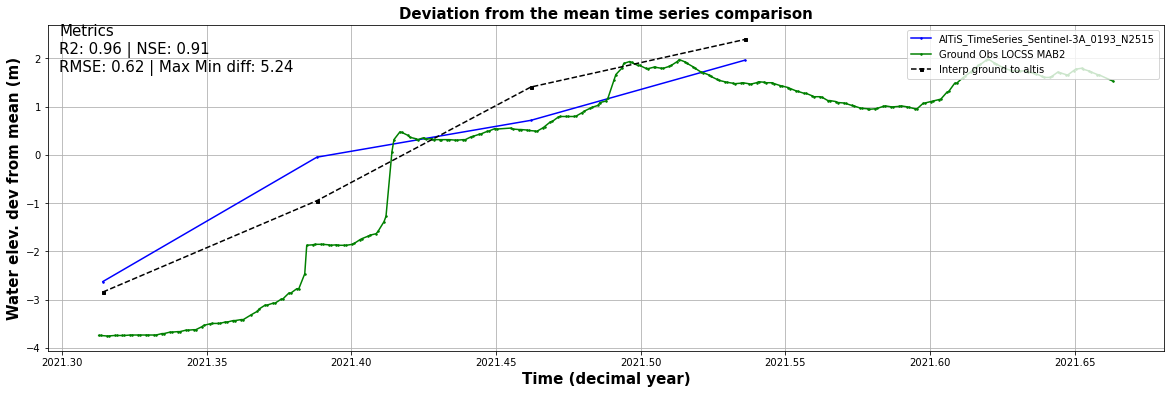

Station America/Sao_Paulo ncolgeoid: GEOID_01_MEDIAN 19060 ground_st: True df_altis: (52, 7)

Altis_min Ground_min:  [2016.4249981026107, 2000.000227686703]

Altis_max Ground_max:  [2021.8946556316591, 2022.2606164383562]
dimension ground altis (8132, 11) (52, 8)
dimension ground altis plot (1998, 11) (51, 8)


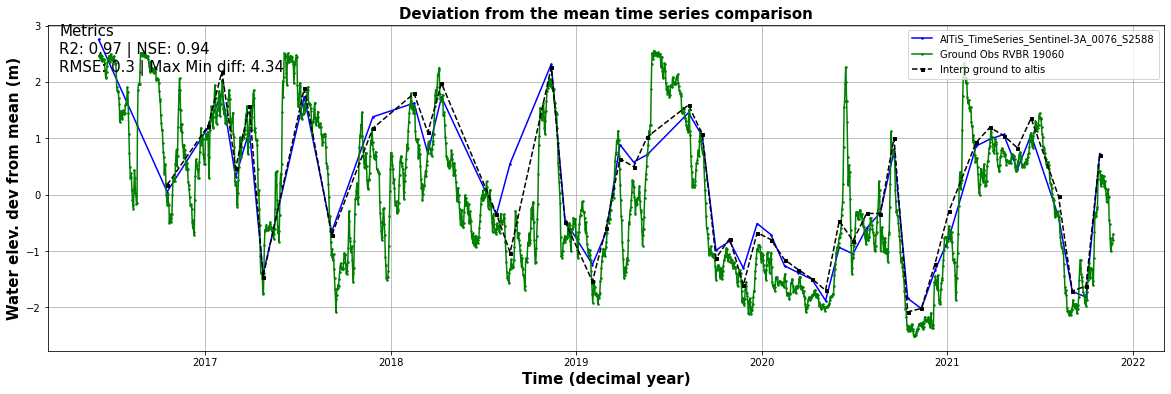

Station America/Sao_Paulo ncolgeoid: GEOID_EIGEN6C4D_MEDIAN 19060 ground_st: True df_altis: (106, 7)

Altis_min Ground_min:  [2017.6767979452054, 2000.000227686703]

Altis_max Ground_max:  [2020.6090733151184, 2022.2606164383562]
dimension ground altis (8132, 11) (106, 8)
dimension ground altis plot (1071, 11) (105, 8)


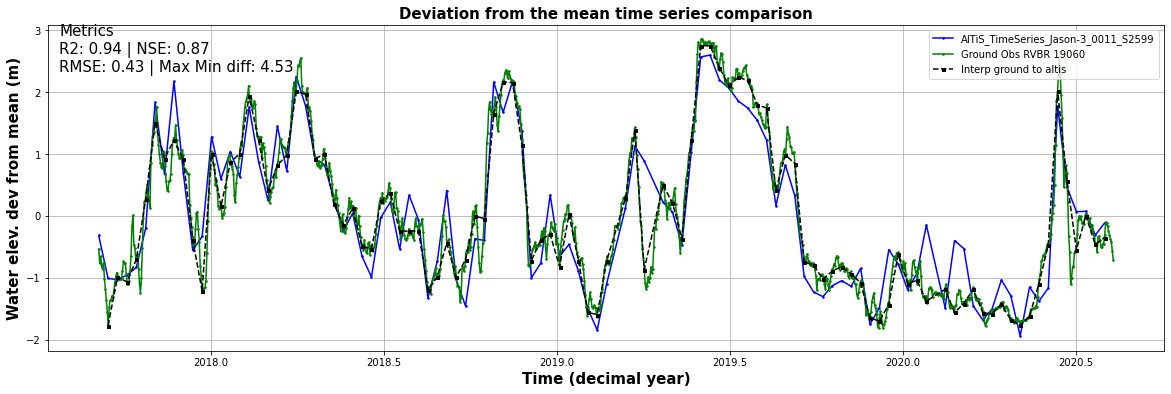

Station America/Maceio ncolgeoid: GEOID_01_MEDIAN 19126 ground_st: True df_altis: (37, 7)

Altis_min Ground_min:  [2019.2068968797564, 2000.000227686703]

Altis_max Ground_max:  [2021.9411453576865, 2022.2633561643836]
dimension ground altis (8133, 11) (37, 8)
dimension ground altis plot (999, 11) (36, 8)


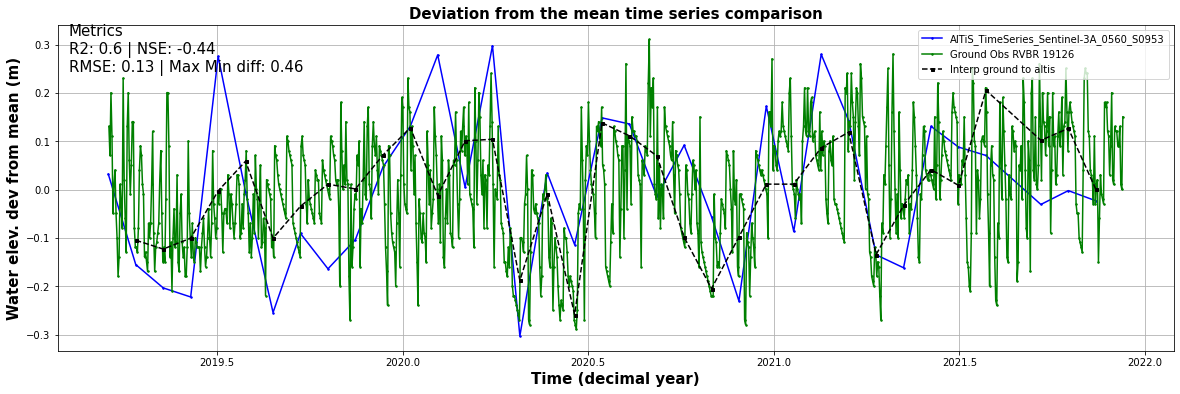

Error: no column geoid_01_median in ../data/alti_timeseries/AlTiS_TimeSeries_Sentinel-3A_0190_S2751.csv
Station America/Sao_Paulo ncolgeoid: GEOID_01_MEDIAN 19069 ground_st: True df_altis: (56, 7)

Altis_min Ground_min:  [2016.4359213721918, 2000.000227686703]

Altis_max Ground_max:  [2021.905608828006, 2022.2578767123289]
dimension ground altis (8131, 11) (56, 8)
dimension ground altis plot (1998, 11) (55, 8)


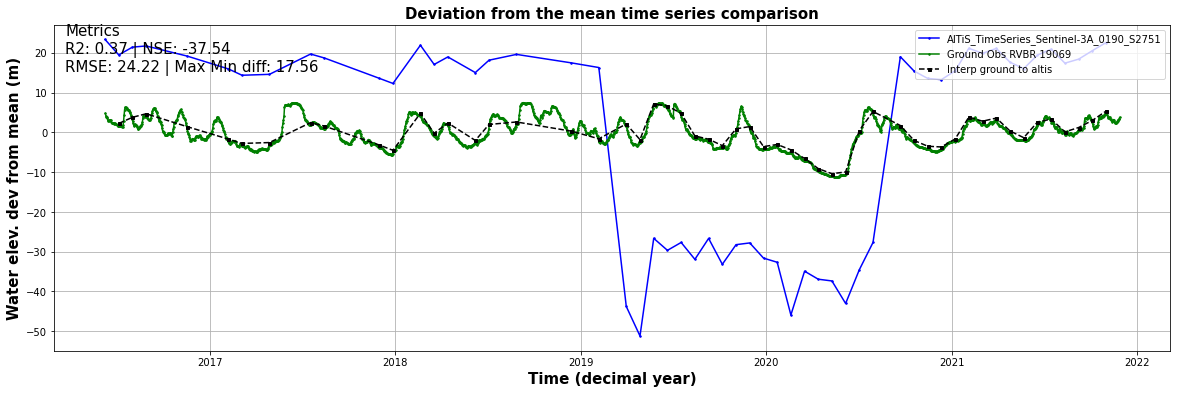

Station America/Chicago ncolgeoid: GEOID_01_MEDIAN 2464800 ground_st: True df_altis: (78, 7)

Altis_min Ground_min:  [2016.2149609137825, 2002.5054794520547]

Altis_max Ground_max:  [2021.905960806697, 2022.0013698630137]
dimension ground altis (7060, 11) (78, 8)
dimension ground altis plot (2056, 11) (77, 8)


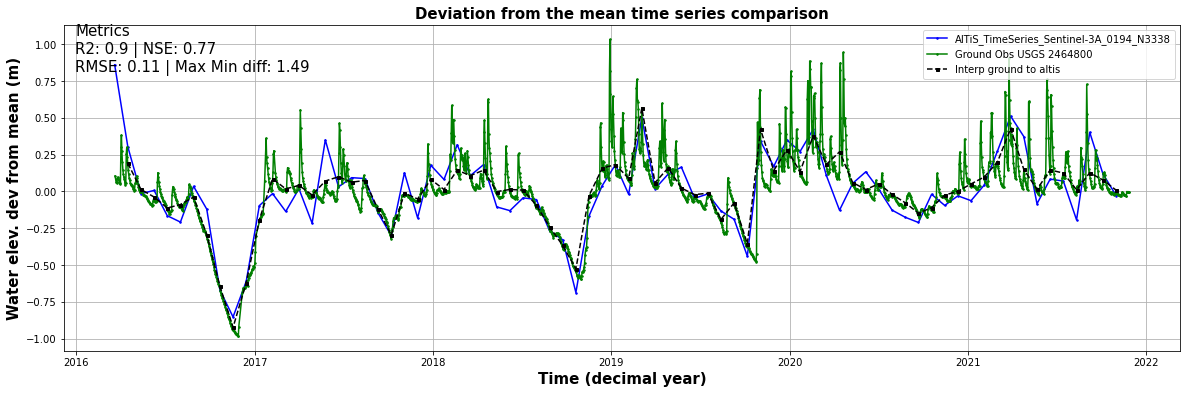

Station America/Chicago ncolgeoid: GEOID_01_MEDIAN 6604000 ground_st: True df_altis: (41, 7)

Altis_min Ground_min:  [2018.9306944444445, 2000.0013661202186]

Altis_max Ground_max:  [2021.886858828006, 2022.0013698630137]
dimension ground altis (7892, 11) (41, 8)
dimension ground altis plot (1036, 11) (40, 8)


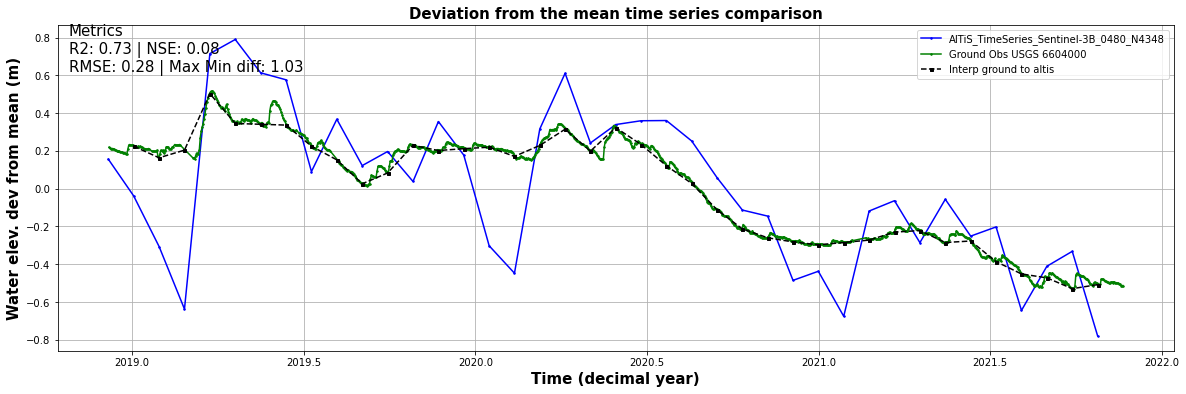

Station America/Chicago ncolgeoid: GEOID_01_MEDIAN 6903880 ground_st: True df_altis: (77, 7)

Altis_min Ground_min:  [2016.183479432301, 2000.75]

Altis_max Ground_max:  [2021.874394977169, 2022.0013698630137]
dimension ground altis (7721, 11) (77, 8)
dimension ground altis plot (2077, 11) (76, 8)


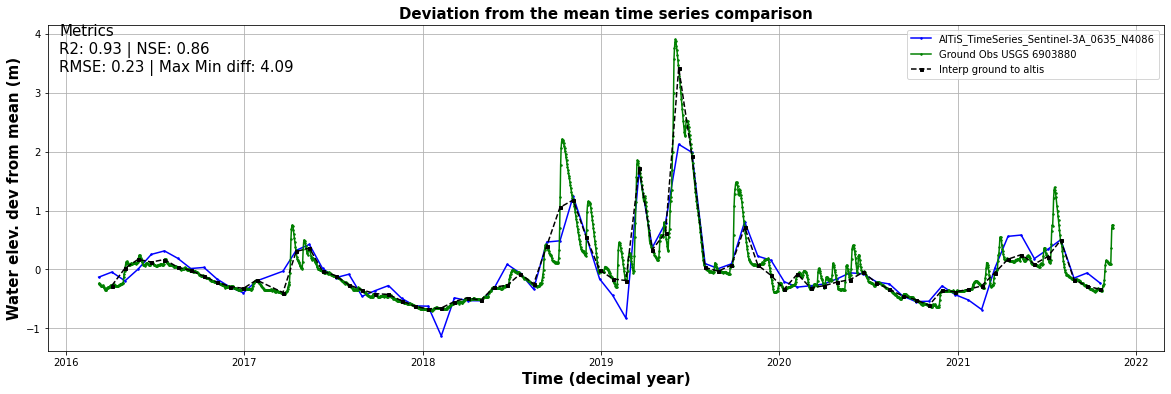

In [17]:
# #read all altiss 


# import geoplot as gplt
# #WRITE AS FUNCTIONS TO MOVE LATER
# #Read shapefile with all the coordinates and the id of the files
#path= '/home/angelica/Dropbox/Research/LOCSS/Denis_Sylvain/15_L_Altis_20220318/lonlat_vs_altis_ed.shp' When it is a shape file
path= '../data/alti_timeseries/lonlat_vs_altis_ed.csv'
lon_fd='lon'
lat_fd='lat'
# altis_shp
#altis_shp=gpd.read_file(path)
altis_csv=pd.read_csv(path)
#Add the time_zone to each coordinate 
tf=TimezoneFinder()
# altis_shp['tz']=[tf.timezone_at(lng=row[0], lat=row[1]) for row in altis_shp[[lon_fd, lat_fd]]]


# altis_shp['tz']=altis_shp.apply(lambda x:tf.timezone_at(lng=x[lon_fd],lat=x[lat_fd]), axis=1)
altis_csv['tz']=altis_csv.apply(lambda x:tf.timezone_at(lng=x[lon_fd],lat=x[lat_fd]), axis=1)

#filter only altis time series with ground observations
# altis_w_gts_shp=altis_shp.loc[altis_shp['station_id'].notna()]
altis_w_gts_csv=altis_csv.loc[altis_csv['station_id'].notna()]


#Read each file and convert it to dataframe
g_path='../data/alti_timeseries/'
df_gts=df_ground_ts

st_fd='gauge_id'
st_date_fd='date'
altis_date_fd = 'date'  # Same value for Sentinel-3A/B
altis_height_fd = 'ice1_ku_SurfHeight_alti_median'  # Same value for Sentinel-3A/B
nodataalti=-9999

wse_ref='e'
ncolgeoid='geoid_01_median' #PENDING RAISE AND HANDLE THE EXCEPTION WHEN geoid column not found
#For AlTiS_TimeSeries_Jason-3_GDR-F_0215_S4017 ncolgeoid=geoid_median (m)
# For AlTiS_TimeSeries_Sentinel-3A_0076_S2588 not geoid column Generating with Geoid in the meantime
# AlTiS_TimeSeries_Jason-3_0011_S2599 ncolgeoid=geoid_eigen6c4d_median (m)
#AlTiS_TimeSeries_Sentinel-3A_0190_S2751  not geoid column Generating with Geoid in the meantime
time_fig=datetime.now().strftime("%Y%m%d_%H_%M")
path_name='../data/plots_'+time_fig+'/'
i=1
df_final_altis=pd.DataFrame()
df_final_ground=pd.DataFrame()


for index,row in altis_w_gts_csv.iterrows():
    # print(row['station_id'])
    altis_name=row['altivs_nam']
    st_id=row['station_id']
    ncolgeoid=row['ncolgeoid']
    # Call every altis relative to the ellipsoide
    
    # is_Sentinel=altis_name.find('Sentinel-3')
    # if is_Sentinel!=-1:
    if ncolgeoid!='No':
        #Call the function with geoid field and wse_type='e'
        df_altis, df_ground_st=open_match_station_altis(g_path,altis_name, st_fd, df_gts, st_id,altis_date_fd, altis_height_fd,
                                                        nodataalti,ncolgeoid=ncolgeoid,wse_ref=wse_ref)
    else:
        #Call the function with geoid field and wse_type='g'
        df_altis, df_ground_st=open_match_station_altis(g_path,altis_name, st_fd, df_gts, st_id,altis_date_fd, altis_height_fd, nodataalti)
    
    print('Station '+row['tz']+' ncolgeoid: '+str(ncolgeoid).upper(), st_id+' ground_st: '+str(not df_ground_st.empty)+' df_altis: '+str(df_altis.shape))
    if not df_ground_st.empty:
        # print('df_altis\n', df_altis.head(3))
        # print('df_ground_st '+st_id+'\n', df_ground_st.head(3))
        df_altis['ground_st_1']=st_id
        #Convert time in df_gts_st to UTC
        source=df_ground_st['source'].iloc[0]
        #if source !='RVBR':
        #     continue
            
       # df_ground_st['date_utc']=df_ground_st[st_date_fd].dt.tz_localize(row['tz']).dt.tz_convert('utc')
        df_ground_st['date_utc']=[timezone(row['tz']).localize(date).astimezone(utc.zone) for date in df_ground_st[st_date_fd]]
        # print(df_ground_st.head(), st_id)
        
       
        #print('\nBefore: '+st_id+'\n', df_ground_st[[st_date_fd,'date_utc','decimal_y']].head())
        #Recalculate date with dates in utc
        if source=='USGS':
            df_ground_st=get_date_time_cols(df_ground_st, 'date_utc', has_hour=False)
        else:
            df_ground_st=get_date_time_cols(df_ground_st, 'date_utc', has_hour=True)
        #print('\nAfter: '+st_id+'\n', df_ground_st[[st_date_fd,'date_utc','decimal_y']].head())
        df_ground_st=df_ground_st.sort_values(by=['decimal_y'])
        df_altis=df_altis.sort_values(by=['decimal_y'])
        
        df_ground_st['altis_d_1']=altis_name

        #Concat to final dataframes 
        df_final_altis=pd.concat((df_final_altis, df_altis), axis=0)
        df_final_ground=pd.concat((df_final_ground, df_ground_st), axis=0)

        #Get the max and mins
        altis_min=df_altis['decimal_y'].min()
        ground_min=df_ground_st['decimal_y'].min()
        
        altis_max=df_altis['decimal_y'].max()
        ground_max=df_ground_st['decimal_y'].max()
        
        print('\nAltis_min Ground_min: ',[altis_min, ground_min])
        print('\nAltis_max Ground_max: ',[altis_max, ground_max])
        #print('\nAltis_min Ground_min: ',[altis_min, ground_min])
        if altis_min>=ground_min:
            min_lim=altis_min
        else:
            min_lim=ground_min
        
        if altis_max<=ground_max:
            max_lim=altis_max
        else:
            max_lim=ground_max
        
        print('dimension ground altis', str(df_ground_st.shape)+' '+str(df_altis.shape))
        df_ground_plot=df_ground_st.loc[(df_ground_st['decimal_y']>=min_lim)&(df_ground_st['decimal_y']<max_lim)].copy()
        df_altis_plot=df_altis.loc[(df_altis['decimal_y']>=min_lim)&(df_altis['decimal_y']<max_lim)].copy()
        
        print('dimension ground altis plot', str(df_ground_plot.shape)+' '+str(df_altis_plot.shape))

        (inh_2_altidy, corr_alti_insi, ns_alti_insi, rmse_alti_insi,
         ampl_insi) = interp_ts12ts2_stat(df_ground_plot['decimal_y'].to_numpy(), df_ground_plot['height'].to_numpy(), 
                                          df_altis_plot['decimal_y'].to_numpy(), df_altis_plot['height'].to_numpy())

        error_m_text='\nR2: '+str(np.round(corr_alti_insi, decimals=2))+' | '+\
        'NSE: '+str(np.round(ns_alti_insi,decimals=2))+'\n'+\
        'RMSE: '+str(np.round(rmse_alti_insi,decimals=2))+' | '+\
        'Max Min diff: '+str(np.round(ampl_insi,decimals=2))+'\n'

        labels=altis_name
        labelg='Ground Obs '+source+' '+st_id
        labeli='Interp ground to altis'

        output_f=path_name

        dfs=df_altis_plot
        dfg=df_ground_plot
        dic_intp={'decimal_y':df_altis_plot['decimal_y'].to_numpy(), 'height':inh_2_altidy}

        dfi=pd.DataFrame(dic_intp)
        date_plot_fd='decimal_y'
        height_plot_fd='height'
        nfig=i
        
        p=plot_dev_mean(nfig,dfs, dfg, dfi, source, st_id, altis_name, date_plot_fd, height_plot_fd, labels, labelg, labeli, error_m_text, output_f)
        p.show()
        p.close()

        i=i+1
        
        
    
    #['gauge_id','source'
    
# def open_match__plot_station_altis(g_path,altis_name, st_id, df_gts, altis_date_fd, altis_height_fd, nodataalti=-9999):


<ipython-input-133-58e5424b45ad>:104: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(i, figsize=(20, 6))


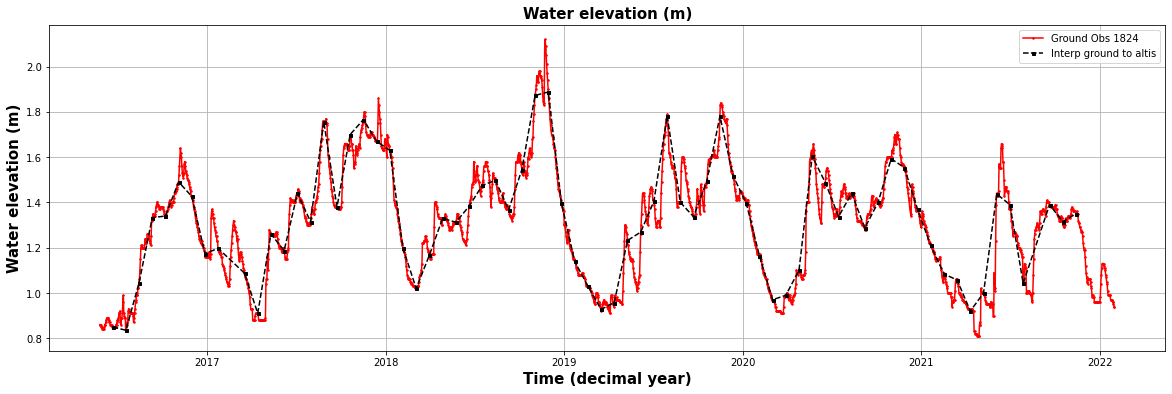

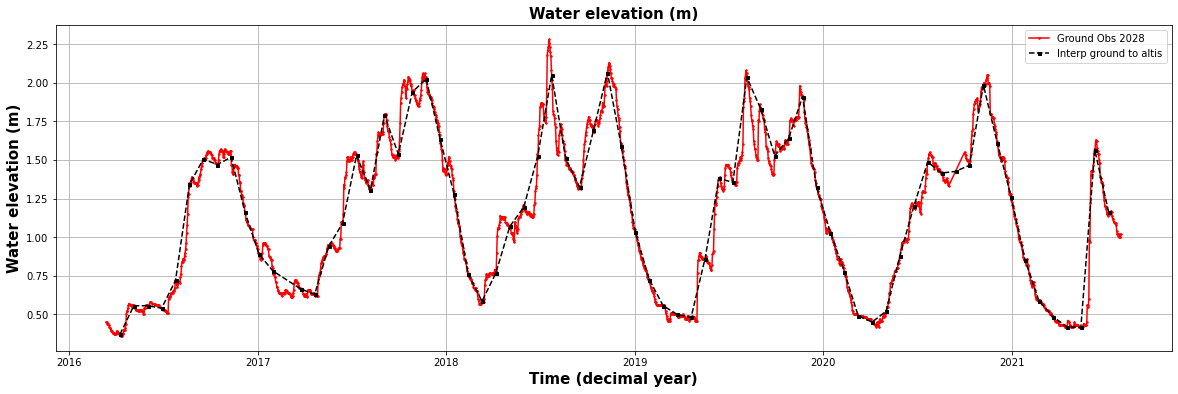

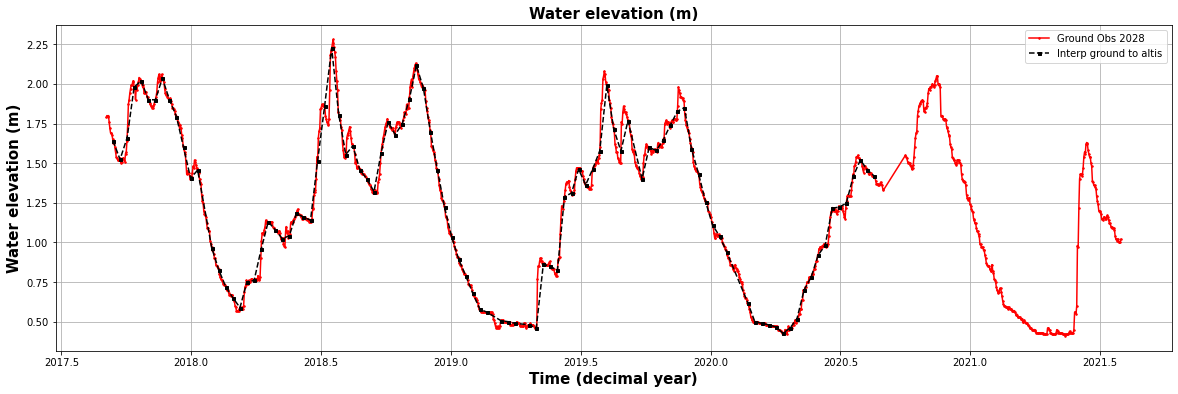

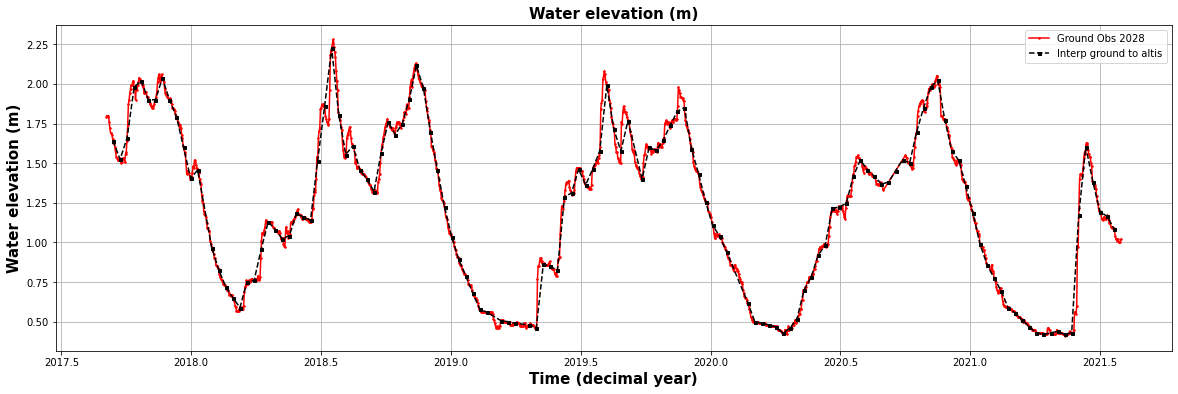

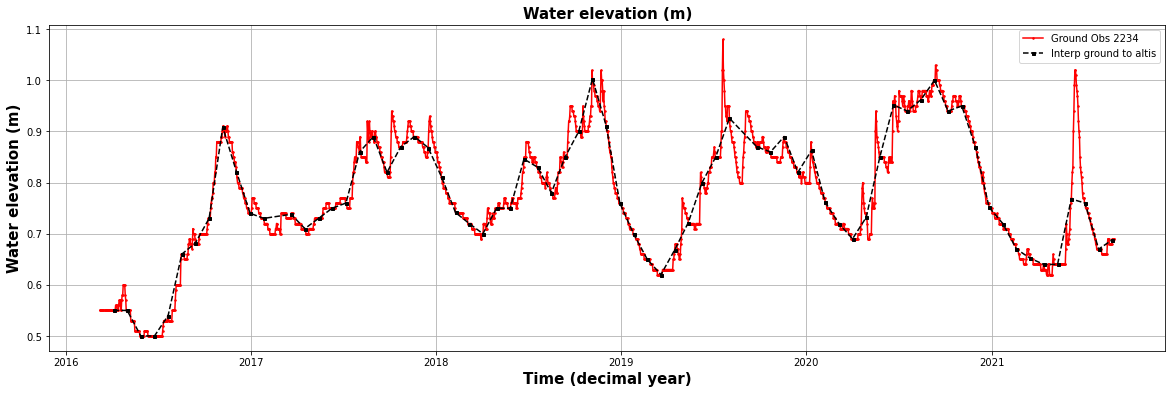

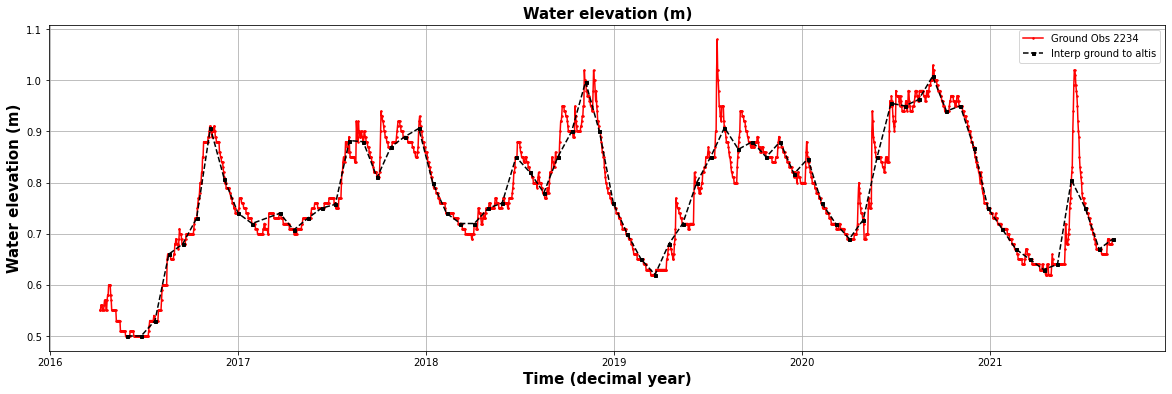

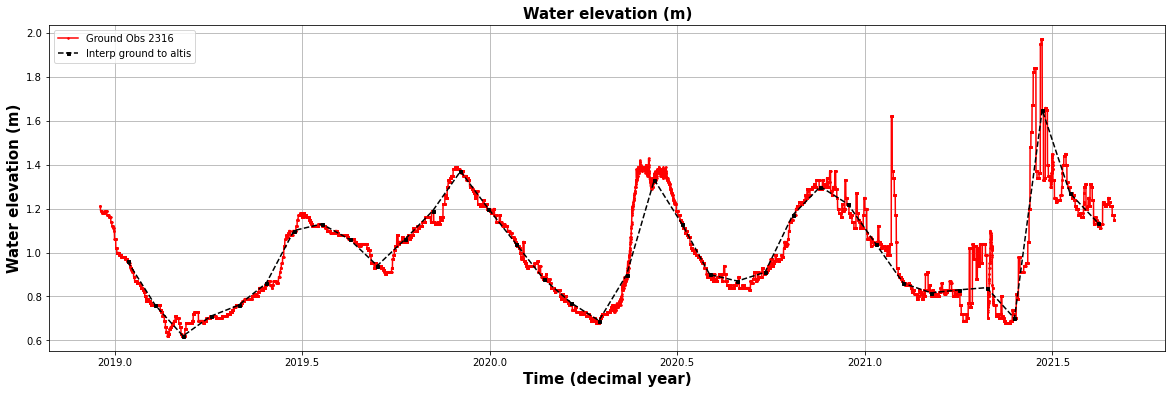

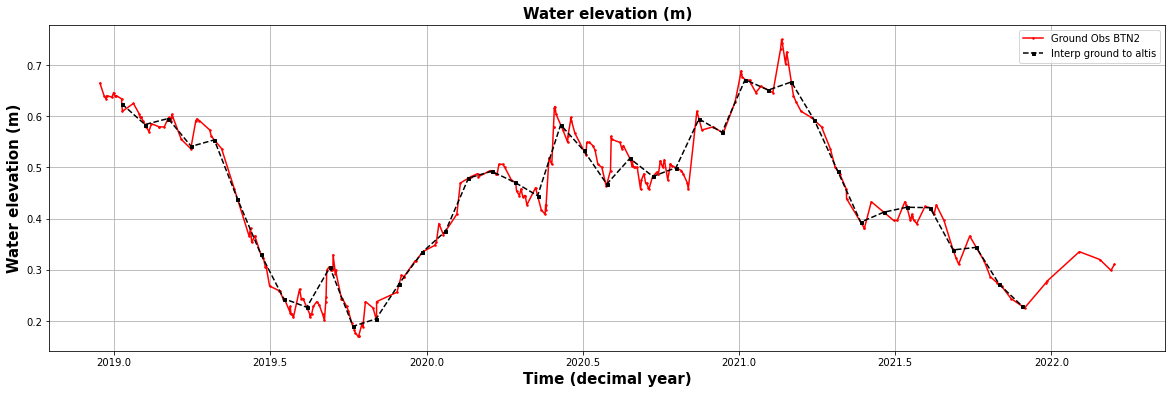

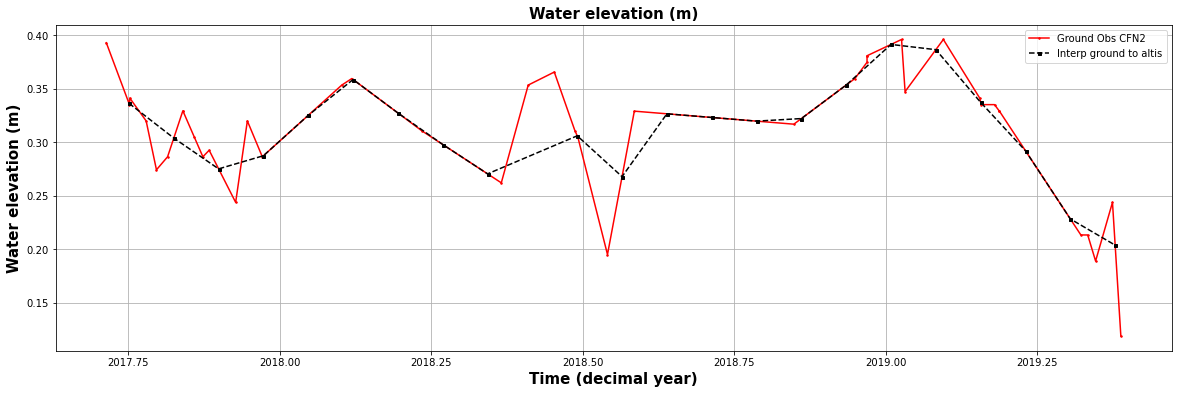

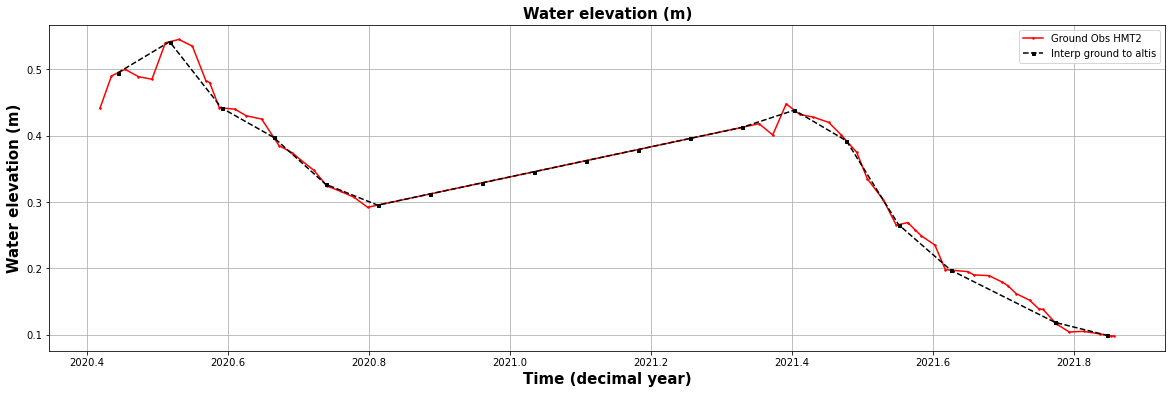

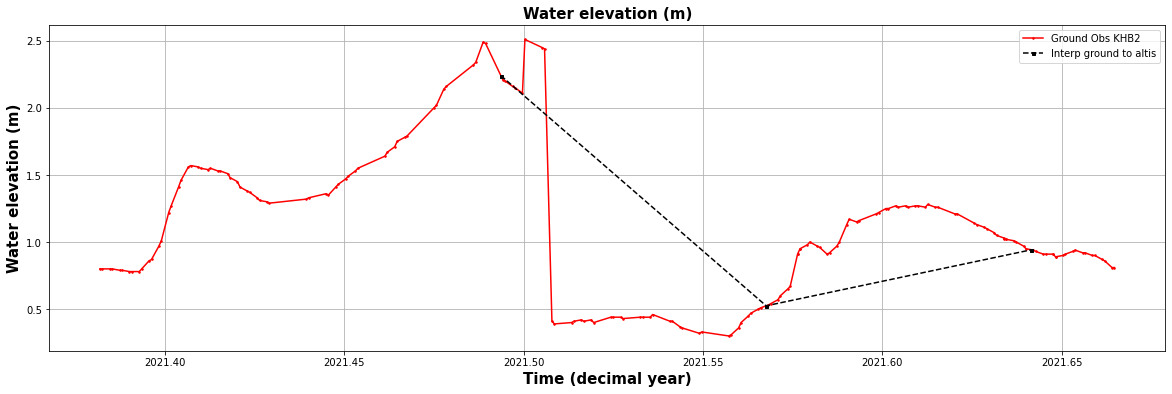

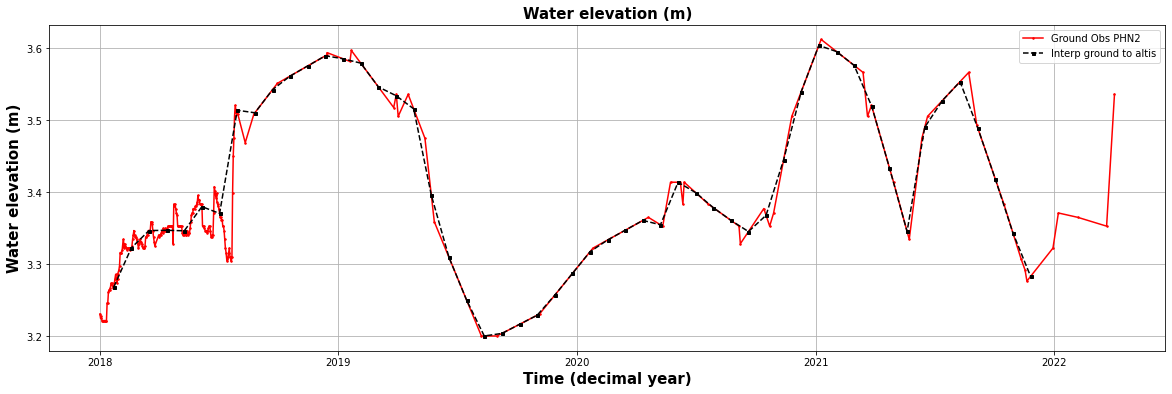

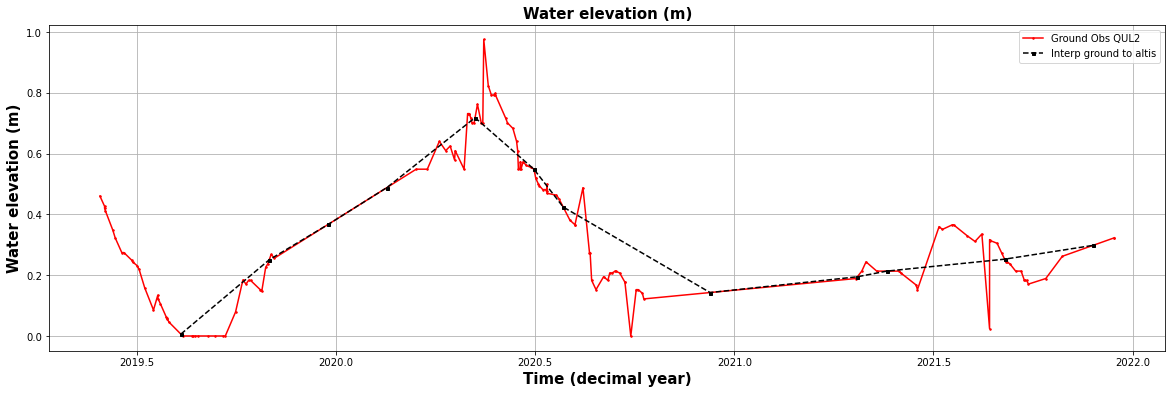

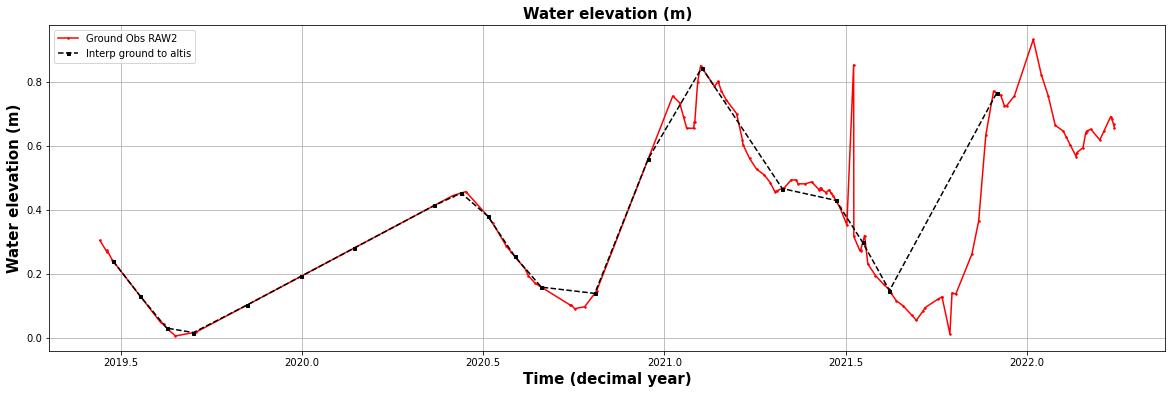

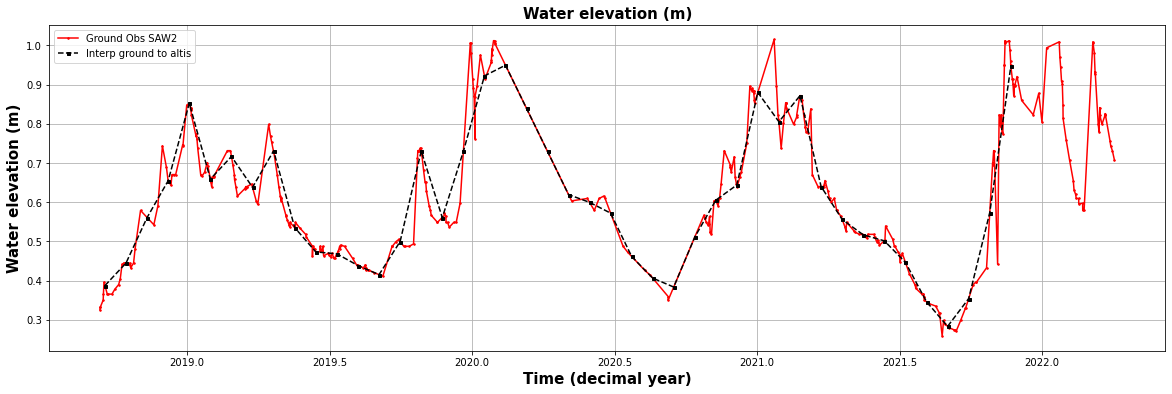

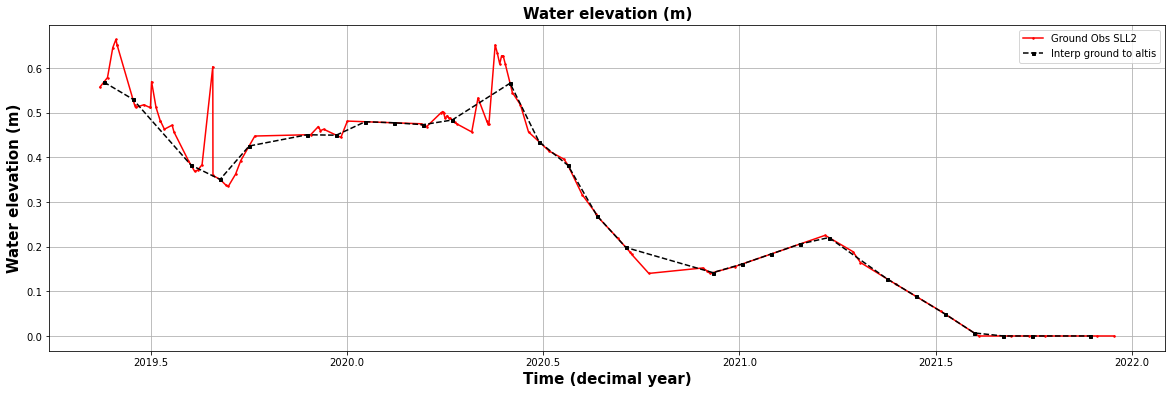

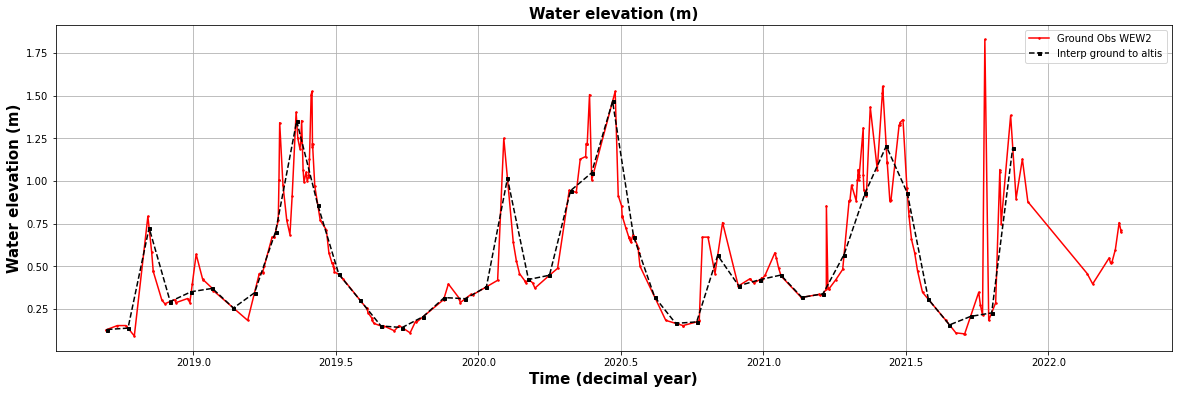

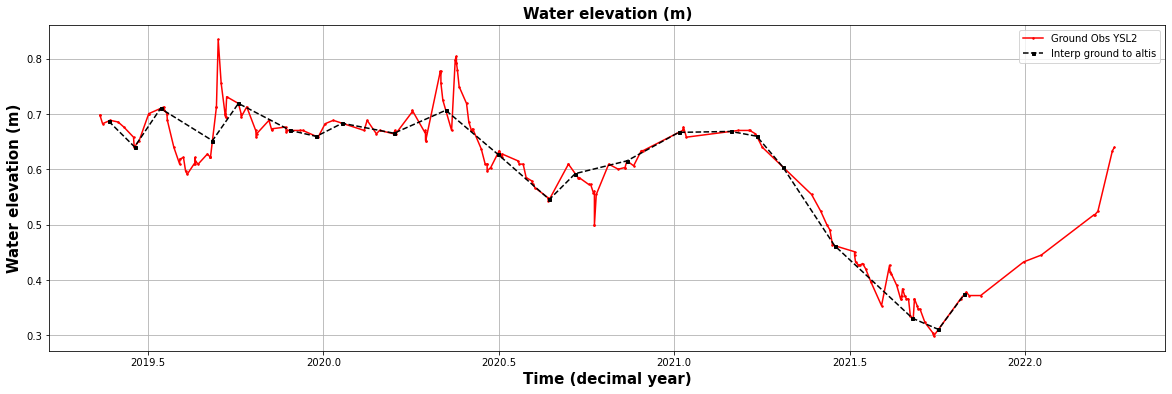

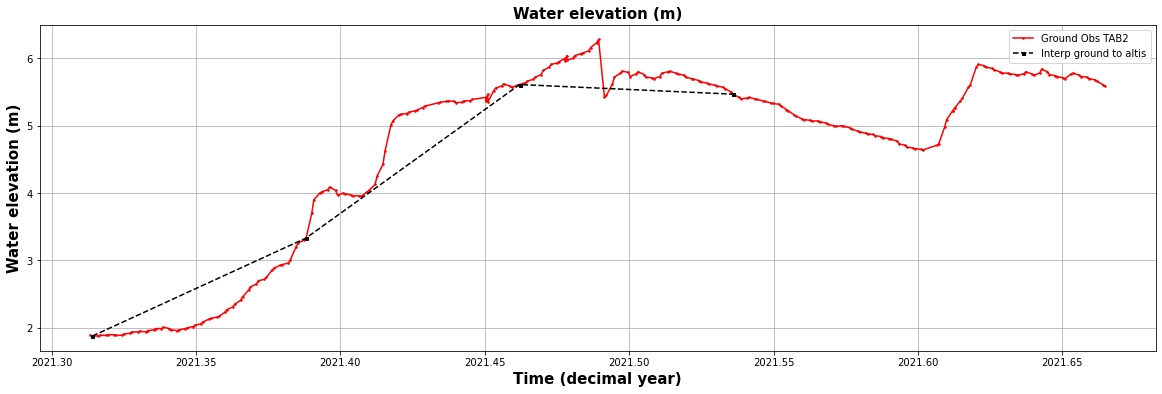

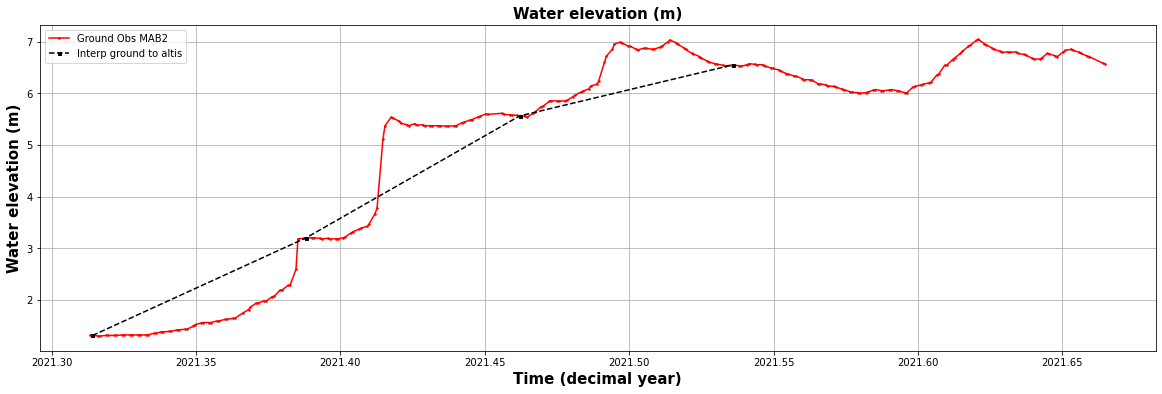

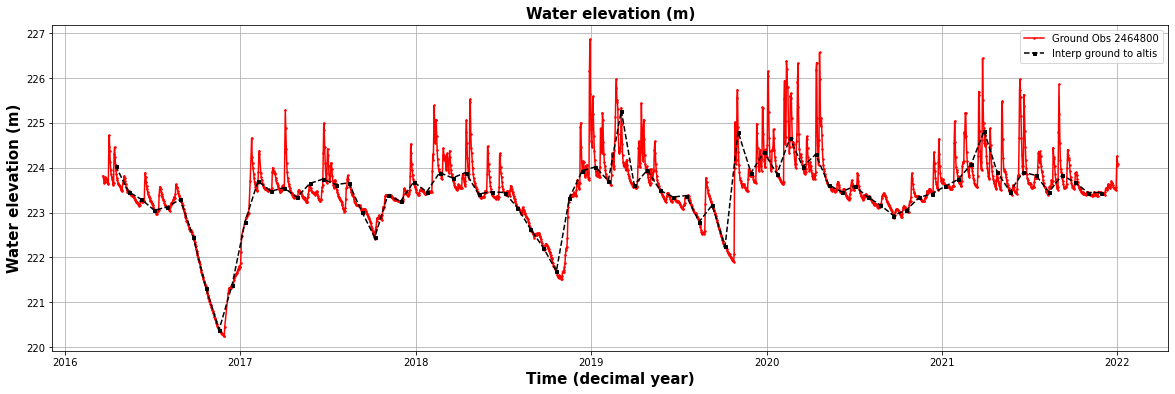

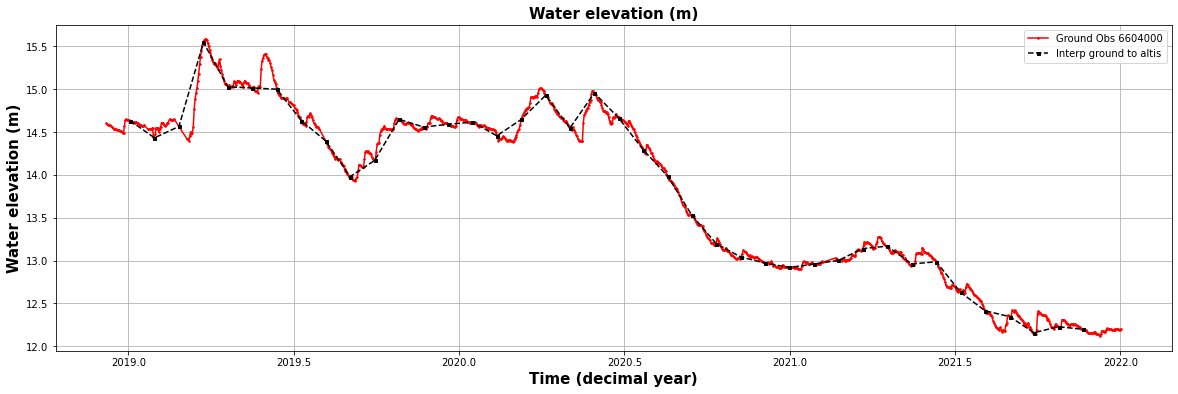

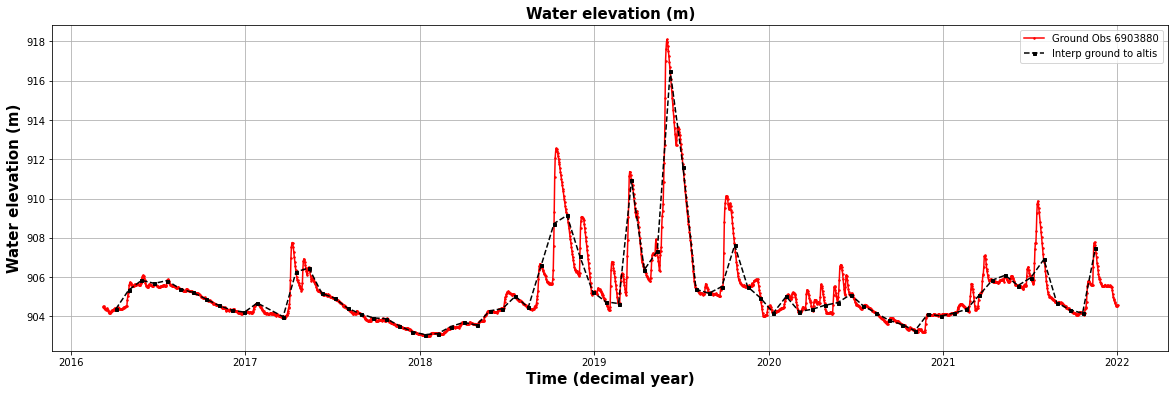

In [133]:
# #read all altiss 


# import geoplot as gplt
# #WRITE AS FUNCTIONS TO MOVE LATER
# #Read shapefile with all the coordinates and the id of the files
#path= '/home/angelica/Dropbox/Research/LOCSS/Denis_Sylvain/15_L_Altis_20220318/lonlat_vs_altis_ed.shp' When it is a shape file
path= '../data/alti_timeseries/lonlat_vs_altis_ed.csv'
lon_fd='lon'
lat_fd='lat'
# altis_shp
#altis_shp=gpd.read_file(path)
altis_csv=pd.read_csv(path)
#Add the time_zone to each coordinate 
tf=TimezoneFinder()
# altis_shp['tz']=[tf.timezone_at(lng=row[0], lat=row[1]) for row in altis_shp[[lon_fd, lat_fd]]]


# altis_shp['tz']=altis_shp.apply(lambda x:tf.timezone_at(lng=x[lon_fd],lat=x[lat_fd]), axis=1)
altis_csv['tz']=altis_csv.apply(lambda x:tf.timezone_at(lng=x[lon_fd],lat=x[lat_fd]), axis=1)

#filter only altis time series with ground observations
# altis_w_gts_shp=altis_shp.loc[altis_shp['station_id'].notna()]
altis_w_gts_csv=altis_csv.loc[altis_csv['station_id'].notna()]
# print(altis_shp.shape)
# print(altis_w_gts_shp.shape)
# print(altis_w_gts_shp.columns)
# print(altis_csv.shape)
# print(altis_w_gts_csv.shape)
# print(altis_w_gts_csv.columns)

#Read each file and convert it to dataframe
g_path='../data/alti_timeseries/'
df_gts=df_ground_ts

st_fd='gauge_id'
st_date_fd='date'
altis_date_fd = 'date'  # Same value for Sentinel-3A/B
altis_height_fd = 'ice1_ku_SurfHeight_alti_median'  # Same value for Sentinel-3A/B
nodataalti=-9999
i=1
df_final_altis=pd.DataFrame()
df_final_ground=pd.DataFrame()

for index,row in altis_w_gts_csv.iterrows():
    # print(row['station_id'])
    altis_name=row['altivs_nam']
    st_id=row['station_id']
    
    df_altis, df_ground_st=open_match_station_altis(g_path,altis_name, st_fd, df_gts, st_id,altis_date_fd, altis_height_fd, nodataalti)
    
    if not df_ground_st.empty:
        # print('df_altis\n', df_altis.head(3))
        # print('df_ground_st '+st_id+'\n', df_ground_st.head(3))
        df_altis['ground_st_1']=st_id
        source=df_ground_st['source'].iloc[0]
        if source=='RVBR':
            continue
        #Convert time in df_gts_st to UTC
        
        df_ground_st['date_utc']=df_ground_st[st_date_fd].dt.tz_localize(row['tz']).dt.tz_convert('utc')
        #print(df_ground_st.head(), st_id)
        
        #print('\nBefore: '+st_id+'\n', df_ground_st[[st_date_fd,'date_utc','decimal_y']].head())
        if source=='USGS':
            df_ground_st=get_date_time_cols(df_ground_st, st_date_fd, has_hour=False)
        else:
            df_ground_st=get_date_time_cols(df_ground_st, st_date_fd, has_hour=True)
        #print('\nAfter: '+st_id+'\n', df_ground_st[[st_date_fd,'date_utc','decimal_y']].head())
        df_ground_st=df_ground_st.sort_values(by=['decimal_y'])
        df_ground_st['altis_d_1']=altis_name

        #Concat to final dataframes 
        df_final_altis=pd.concat((df_final_altis, df_altis), axis=0)
        df_final_ground=pd.concat((df_final_ground, df_ground_st), axis=0)

        #Get the max and mins
        altis_min=df_altis['decimal_y'].min()
        ground_min=df_ground_st['decimal_y'].min()
        altis_max=df_altis['decimal_y'].max()
        ground_max=df_ground_st['decimal_y'].max()
        # print('\nAltis_min Ground_min: ',[altis_min, ground_min])
        # print('\nAltis_max Ground_max: ',[altis_max, ground_max])
        #print('\nAltis_min Ground_min: ',[altis_min, ground_min])
        if altis_min>ground_min:
            df_ground_plot=df_ground_st.loc[(df_ground_st['decimal_y']>=altis_min)]#&(df_ground_st['decimal_y']<altis_max)]
            df_altis_plot=df_altis
        else:
            df_ground_plot=df_ground_st
            df_altis_plot=df_altis.loc[(df_altis['decimal_y']>=ground_min)]#&(df_ground_st['decimal_y']<altis_max)]


        (inh_2_altidy, corr_alti_insi, ns_alti_insi, rmse_alti_insi,
         ampl_insi) = interp_ts12ts2_stat(df_ground_plot['decimal_y'].to_numpy(), df_ground_plot['height'].to_numpy(), 
                                          df_altis_plot['decimal_y'].to_numpy(), df_altis_plot['height'].to_numpy())

        error_m_text='\nR2: '+str(np.round(corr_alti_insi, decimals=2))+' | '+\
        'NSE: '+str(np.round(ns_alti_insi,decimals=2))+'\n'+\
        'RMSE: '+str(np.round(rmse_alti_insi,decimals=2))+' | '+\
        'Max Min diff: '+str(np.round(ampl_insi,decimals=2))+'\n'



        plt.figure(i, figsize=(20, 6))
        gplot=plt.plot(df_ground_plot['decimal_y'], 
                       df_ground_plot['height'], '-go', markersize=1.5, label='Ground Obs '+st_id)
        iplot=plt.plot(df_altis_plot['decimal_y'].to_numpy(), 
                        inh_2_altidy, '--ks', markersize=3, label='Interp ground to altis')
        #plt.plot(altidy, altiwelev, '-ro', markersize=2.5)
        plt.gca().get_xaxis().get_major_formatter().set_useOffset(False)
        plt.xlabel('Time (decimal year)', size=15, weight='bold')
        plt.ylabel('Water elevation (m)', size=15, weight='bold')
        plt.grid('on')
        plt.legend()
        plt.title('Water elevation (m)', size=15,
                  weight='bold')
        plt.savefig('../data/plots/'+source+'_ground_interp_'+st_id+'_vs_'+altis_name+'.png',
                     bbox_inches='tight')
        i=i+1
        
        
    
    #['gauge_id','source'
    
# def open_match__plot_station_altis(g_path,altis_name, st_id, df_gts, altis_date_fd, altis_height_fd, nodataalti=-9999):


In [134]:
df_altis_plot

decimal_y      height  year  month  day  hour  \
0   2016.183479  275.212348  2016      3    8     3   
1   2016.257250  275.298792  2016      4    4     3   
2   2016.331020  275.150594  2016      5    1     3   
3   2016.404791  275.351242  2016      5   28     3   
4   2016.478561  275.598305  2016      6   24     3   
..          ...         ...   ...    ...  ...   ...   
72  2021.578505  275.578580  2021      7   31     3   
73  2021.652477  274.932534  2021      8   27     3   
74  2021.726450  274.997760  2021      9   23     3   
75  2021.800422  274.833224  2021     10   20     3   
76  2021.874395  275.673569  2021     11   16     3   

                                 name_altis ground_st_1  
0   AlTiS_TimeSeries_Sentinel-3A_0635_N4086     6903880  
1   AlTiS_TimeSeries_Sentinel-3A_0635_N4086     6903880  
2   AlTiS_TimeSeries_Sentinel-3A_0635_N4086     6903880  
3   AlTiS_TimeSeries_Sentinel-3A_0635_N4086     6903880  
4   AlTiS_TimeSeries_Sentinel-3A_0635_N4086     6903880  
..                                      ...         ...  
72  AlTiS_TimeSeries_Sentinel-3A_0635_N4086     6903880  
73  AlTiS_TimeSeries_Sentinel-3A_0635_N4086     6903880  
74  AlTiS_TimeSeries_Sentinel-3A_0635_N4086     6903880  
75  AlTiS_TimeSeries_Sentinel-3A_0635_N4086     6903880  
76  AlTiS_TimeSeries_Sentinel-3A_0635_N4086     6903880  

[77 rows x 8 columns]

In [48]:
df1=go.read_ground_data('LOCSS', station_id=lc_lakes)
# df.shape
# df_locss_filtered=df.loc[df['gauge_id'].isin(lc_lakes)]
# df_locss_filtered.shape
x=df1['gauge_id'].unique()
for a in x:
    print(df1.loc[df1['gauge_id']==a].shape)

(536, 24)
(53, 24)
(170, 24)
(256, 24)
(109, 24)
(393, 24)


In [13]:
df_arhn.head(3)

date  height source gauge_id  year  month  day  hour  \
0 2010-03-01 12:00:00    2.30   ARHN     2830  2010      3    1    12   
1 2010-03-02 12:00:00    2.30   ARHN     2830  2010      3    2    12   
2 2010-03-03 13:00:00    2.31   ARHN     2830  2010      3    3    12   

     decimal_y  
0  2010.163014  
1  2010.165753  
2  2010.168493

In [14]:
df_usgs.head(3)

Unnamed: 0 agency_cd gauge_id       date  height X_00065_00003_cd source  \
0           1      USGS  2464800 2002-07-04  223.73                A   USGS   
1           2      USGS  2464800 2002-07-05  223.66                A   USGS   
2           3      USGS  2464800 2002-07-06  223.61                A   USGS   

   year  month  day  hour    decimal_y  
0  2002      7    4    12  2002.505479  
1  2002      7    5    12  2002.508219  
2  2002      7    6    12  2002.510959